# Start you dataset visualization here  
### modify the analysis_file to the string where the dataframe file (.csv) produced by SymDesign.py analysis lives and the filter_file variable to the provided symdesign/data/filter_and_sort_df.csv

In [5]:
!pwd

/home/kylemeador/symdesign/jupyter_notebooks


In [13]:
analysis_file = '/home/kylemeador/designs/T33/TopNanohedraScoreCentralClusterRepresentatives_CORRECTED.csv'  # YOUR ANALYSIS FILE HERE
hbnet_analysis_file = '/home/kylemeador/designs/RepresentativeDFTop96SelectedDesigns_SC_ICompSim_SolEn_EnDistPoseMetrics-21-05-18-162259.csv'
filtered_analysis_file = '/home/kylemeador/designs/PercentHydroSCFiltered_SC_ICompSim_SolEn_EnDistWeightedDesignPoseMetrics-210430-120519.csv'

Import the required packages

In [2]:
import os
import sys
import math
import operator
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


symdesign_main = os.path.dirname(os.environ.get('SymDesign'))
sys.path.append(symdesign_main)

from DesignMetrics import master_metrics

Magic methods ensure any changes to imported files stay current in the notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
mean = 'mean'
std = 'std'
idx_slice = pd.IndexSlice

In [5]:
def columns_to_new_column(df, column_dict, mode='add'):
    """Find new column values by taking an operation of one column on another

    Args:
        df (pandas.DataFrame): Dataframe where the columns are located
        column_dict (dict): A dictionary with keys as new column names, values as tuple of columns.
            Where value[0] mode(operation) value[1] = key
    Keyword Args:
        mode='add' (str) = What operator to use?
            Viable options are included in module operator, but could be 'sub', 'mul', 'truediv', etc.
    Returns:
        df (pandas.DataFrame): Dataframe with new column values
    """
    for column in column_dict:
        try:
            df[column] = operator.attrgetter(mode)(operator)(df[column_dict[column][0]], df[column_dict[column][1]])
        except KeyError:
            pass

    return df

In [6]:
# need {column: {'direction': 'max', 'val': 0.5, 'idx': []}, ...}
def df_filter_index_by_value(df, **kwargs):
    """Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
    on whether the column should be sorted max/min
    Args:
        df (pandas.DataFrame): DataFrame to filter indices on
    Keyword Args:
        kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
    """
    indices_l = []
    for _index in kwargs:
        if kwargs[_index]['direction'] == 'max':
            kwargs[_index]['idx'] = df[df[_index] >= kwargs[_index]['value']].index.to_list()
        if kwargs[_index]['direction'] == 'min':
            kwargs[_index]['idx'] = df[df[_index] <= kwargs[_index]['value']].index.to_list()
    
    return kwargs

In [7]:
def index_intersection(filtered_indices):
    """Take the intersection of provided indices in key, value pairs
    
    Args:
        filtered_indices (dict): {metric: indices, ...}
    Returns:
        (list): All indices in each provided metric
    """
    final_indices = set()
    # find all set union
    for metric in filtered_indices:
        final_indices = set(final_indices) | set(filtered_indices[metric])
        
    # find all set intersection
    for metric in filtered_indices:
        final_indices = set(final_indices) & set(filtered_indices[metric])
    return list(final_indices)

In [8]:
def return_df_feature_descriptors(df):
    """From a dataframe, return only the numeric features (columns) and their statistcial descriptions
    
    Returns:
        (pandas.DataFrame)
    """
    numerical_df = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(axis=1)
    measures = {'mean': numerical_df.mean(), 
                'std': numerical_df.std(),
                'min': numerical_df.min(),
                'max': numerical_df.max()}
    descriptor_df = pd.DataFrame(measures)
    descriptor_df['range'] = descriptor_df['max'] - descriptor_df['min']
    return pd.concat([descriptor_df], keys=['descriptors'], axis=1)

In [20]:
test_analysis = '/home/kylemeador/designs/SymDesignOutput/Projects/T33_DesignsPoseMetrics-21-05-25-145002.csv'
nano_test_analysis = '/home/kylemeador/designs/SymDesignOutput/Projects/T33_DesignsPoseMetrics-Nano.csv'
df = pd.read_csv(test_analysis, index_col=0, header=[0,1,2])
nano_df = pd.read_csv(nano_test_analysis, index_col=0, header=[0,1,2])

In [21]:
display(df)
display(nano_df)

pose  \
                                                               dock   
                                                   design_dimension   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                0   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                0   

                                                                              \
                                                                               
                                                   entity_1_c_terminal_helix   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                         1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         0   

                                                                                    \
                                                                                     
                                                   entity_1_c_terminal_orientation   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                              -1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                               1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                              -1   

                                                                        \
                                                                         
                                                   entity_1_max_radius   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...           56.382717   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...           73.383201   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...           57.062358   

                                                                              \
                                                                               
                                                   entity_1_n_terminal_helix   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                         1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         0   

                                                                                    \
                                                                                     
                                                   entity_1_n_terminal_orientation   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                               1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                               1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                              -1   

                                                                  \
                                                                   
                                                   entity_1_name   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...        7KDI_1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...        2GTR_1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...        3FWT_1   

                                                                                \
                                                                                 
                                                   entity_1_number_of_residues   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                          33   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         249   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         112   

                                                                      \
                                                                       
                                                   entity_1_symmetry   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                C3   
Proje

pose  \
                                                               dock   
                                                   design_dimension   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                0   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                0   

                                                                              \
                                                                               
                                                   entity_1_c_terminal_helix   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                         1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         0   

                                                                                    \
                                                                                     
                                                   entity_1_c_terminal_orientation   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                              -1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                               1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                              -1   

                                                                        \
                                                                         
                                                   entity_1_max_radius   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...           56.382749   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...           73.383126   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...           57.062346   

                                                                              \
                                                                               
                                                   entity_1_n_terminal_helix   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                         1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         0   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         0   

                                                                                    \
                                                                                     
                                                   entity_1_n_terminal_orientation   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                               1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                               1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                              -1   

                                                                  \
                                                                   
                                                   entity_1_name   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...        1zvb_1   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...        2gtr_1   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...        3fwt_1   

                                                                                \
                                                                                 
                                                   entity_1_number_of_residues   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                          33   
Projects-T33_Designs-2gtr_2dj6-DEGEN_1_2-ROT_19...                         249   
Projects-T33_Designs-3fwt_2gtr-DEGEN_1_1-ROT_12...                         112   

                                                                      \
                                                                       
                                                   entity_1_symmetry   
Projects-T33_Designs-1zvb_4gvr-DEGEN_1_1-ROT_2_...                C3   
Proje

In [34]:
df = pd.read_csv(analysis_file, index_col=0, header=[0,1,2])
filtered_df = pd.read_csv(filtered_analysis_file, index_col=0, header=[0,1,2])

In [15]:
df = pd.read_csv(hbnet_analysis_file, index_col=0, header=[0,1,2])

In [16]:
df = df.rename_axis(columns=['protocol', 'measure', 'metric'])
print('Starting size')
display(df.shape)
# outliers = (df.loc[:, idx_slice['pose', mean, 'int_energy_res_summary_unbound']] >= 10)  # .any(axis=1) if using multiple columns
# df = df.loc[~outliers, :]  # .any(axis=0)
# print('Removing energy outliers')
# display(df.shape)
df.dropna(inplace=True, thresh=100)  #, thresh= , subset=[])
# if a certain number of columns should be present add -> thresh=100, 
# if a certain column should be checked add -> subset=['nanohedra_score', 'shape_complementarity']
print('Removing missing values')
display(df.shape)

Starting size


(96, 596)

Removing missing values


(96, 596)

In [23]:
filtered_df = filtered_df.rename_axis(columns=['protocol', 'measure', 'metric'])
print('Starting size')
display(filtered_df.shape)
# outliers = (df.loc[:, idx_slice['pose', mean, 'int_energy_res_summary_unbound']] >= 10)  # .any(axis=1) if using multiple columns
# df = df.loc[~outliers, :]  # .any(axis=0)
# print('Removing energy outliers')
# display(df.shape)
filtered_df.dropna(inplace=True, thresh=100)  #, thresh= , subset=[])
# if a certain number of columns should be present add -> thresh=100, 
# if a certain column should be checked add -> subset=['nanohedra_score', 'shape_complementarity']
print('Removing missing values')
display(filtered_df.shape)

Starting size


(410, 195)

Removing missing values


(410, 195)

## Visualize data descriptors (mean, standard deviation, min, max, range) for the dataframe

Here is the cumulative analysis of HBNet protocols versus design_profile and no_constraint

In [17]:
df.describe()

protocol           hbnet                                                    \
measure  energy_distance                             mean                    
metric    design_profile no_constraint HBNet_NumUnsatHpol HBNet_Saturation   
count          95.000000     95.000000               95.0        95.000000   
mean           10.678855     10.867665                0.0         0.832205   
std             1.419753      1.430349                0.0         0.059935   
min             7.774684      7.534224                0.0         0.635047   
25%             9.652265      9.919515                0.0         0.790704   
50%            10.697910     10.775523                0.0         0.832230   
75%            11.653900     11.955971                0.0         0.870730   
max            13.837704     14.393033                0.0         0.961167   

protocol                                                                      \
measure                                                                        
metric   HBNet_Score buns_1_unbound buns_1_unbound_ignore buns_1_unbound_sym   
count      95.000000      95.000000             95.000000          95.000000   
mean        0.176581       2.074486              1.151220           2.077644   
std         0.095792       1.466042              1.024001           1.464461   
min         0.052661       0.000000              0.000000           0.000000   
25%         0.121230       1.000000              0.300000           1.000000   
50%         0.160377       1.900000              0.900000           1.900000   
75%         0.205709       2.750000              1.662500           2.750000   
max         0.609047       6.100000              4.700000           6.100000   

protocol                                                                 \
measure                                                                   
metric   buns_1_unbound_sym_ignore buns_2_unbound buns_2_unbound_ignore   
count                    95.000000      95.000000             95.000000   
mean                      1.151220       1.675915              1.010280   
std                       1.024001       1.186561              0.869084   
min                       0.000000       0.000000              0.000000   
25%                       0.300000       0.844444              0.400000   
50%                       0.900000       1.400000              0.800000   
75%                       1.662500       2.387500              1.387500   
max                       4.700000       5.285714              4.142857   

protocol                                                          \
measure                                                            
metric   buns_2_unbound_sym buns_2_unbound_sym_ignore   buns_asu   
count             95.000000                 95.000000  95.000000   
mean               1.681441                  1.010280   0.237632   
std                1.191227                  0.869084   1.009456   
min                0.000000                  0.000000   0.000000   
25%                0.844444                  0.400000   0.000000   
50%                1.400000                  0.800000   0.000000   
75%                2.387500                  1.387500   0.000000   
max                5.285714                  4.142857   5.700000   

protocol                                                                  \
measure                                                                    
metric   buns_asu_hpol buns_complex buns_complex_ignore buns_complex_sym   
count        95.000000    95.000000           95.000000        95.000000   
mean          0.104737     6.442678            5.371236         6.505363   
std           0.466772     3.162482            2.732037         3.177452   
min           0.000000     1.200000            0.600000         1.300000   
25%           0.000000     3.850000            3.300000         3.900000   
50%           0.000000     6.200000            5.100000         6.200000   
7

In [63]:
des_df = df.loc[:, idx_slice[protocols_of_interest.keys(), ['mean', 'sequence_design'], set(metrics_of_interest.keys()).difference({'observed_evolution', 'percent_rim', 'percent_core', 'rmsd_complex'})]].droplevel(1, axis=1).swaplevel(0,1, axis=1).sort_index(level=0, axis=1).describe().drop('count').round(2)

In [64]:
des_df

metric   interface_area_total                        interface_energy         \
protocol       design_profile    hbnet no_constraint   design_profile  hbnet   
mean                  1342.12  1310.64       1356.52           -38.47 -22.21   
std                    346.76   350.98        352.79            11.21  11.12   
min                    724.15   625.75        709.07           -65.51 -44.06   
25%                   1112.33  1068.79       1117.65           -45.58 -29.67   
50%                   1322.85  1296.41       1346.28           -39.45 -22.67   
75%                   1544.24  1503.94       1566.68           -30.18 -15.70   
max                   2388.68  2322.28       2395.39            -7.62   6.93   

metric                  number_hbonds                       \
protocol no_constraint design_profile  hbnet no_constraint   
mean            -40.69           4.72   5.48          4.64   
std              11.28           2.08   1.95          2.15   
min             -65.18           0.43   1.80          0.33   
25%             -48.05           3.21   3.80          3.19   
50%             -40.70           4.62   5.40          4.30   
75%             -33.40           5.95   6.70          6.21   
max             -12.75          10.00  12.50         11.75   

metric   percent_interface_area_hydrophobic                      \
protocol                     design_profile hbnet no_constraint   
mean                                   0.77  0.72          0.78   
std                                    0.04  0.04          0.05   
min                                    0.66  0.61          0.65   
25%                                    0.74  0.69          0.75   
50%                                    0.77  0.73          0.78   
75%                                    0.80  0.76          0.81   
max                                    0.89  0.82          0.88   

metric   shape_complementarity                     solvation_energy         \
protocol        design_profile hbnet no_constraint   design_profile  hbnet   
mean                      0.72  0.68          0.73            -8.19 -16.38   
std                       0.03  0.04          0.03             7.06   6.44   
min                       0.67  0.56          0.65           -30.85 -34.66   
25%                       0.70  0.66          0.71           -11.62 -20.84   
50%                       0.72  0.68          0.73            -7.17 -16.29   
75%                       0.75  0.70          0.75            -3.40 -11.24   
max                       0.80  0.79          0.81             7.85  -2.74   

metric                  
protocol no_constraint  
mean             -6.67  
std               6.64  
min             -26.05  
25%             -10.96  
50%              -6.02  
75%              -1.80  
max               7.52

In [67]:
map_column_level(des_df, metrics_of_interest, level=0)
map_column_level(des_df, protocols_of_interest, level=1)

In [68]:
des_df

metric   Buried Surface Area (BSA)                                \
protocol       Tertiary Constraint Hydrogen-Bond Search     Free   
mean                       1342.12              1310.64  1356.52   
std                         346.76               350.98   352.79   
min                         724.15               625.75   709.07   
25%                        1112.33              1068.79  1117.65   
50%                        1322.85              1296.41  1346.28   
75%                        1544.24              1503.94  1566.68   
max                        2388.68              2322.28  2395.39   

metric   Predicted Binding Energy                              \
protocol      Tertiary Constraint Hydrogen-Bond Search   Free   
mean                       -38.47               -22.21 -40.69   
std                         11.21                11.12  11.28   
min                        -65.51               -44.06 -65.18   
25%                        -45.58               -29.67 -48.05   
50%                        -39.45               -22.67 -40.70   
75%                        -30.18               -15.70 -33.40   
max                         -7.62                 6.93 -12.75   

metric               H-bonds                               % Hydrophobic BSA  \
protocol Tertiary Constraint Hydrogen-Bond Search   Free Tertiary Constraint   
mean                    4.72                 5.48   4.64                0.77   
std                     2.08                 1.95   2.15                0.04   
min                     0.43                 1.80   0.33                0.66   
25%                     3.21                 3.80   3.19                0.74   
50%                     4.62                 5.40   4.30                0.77   
75%                     5.95                 6.70   6.21                0.80   
max                    10.00                12.50  11.75                0.89   

metric                              Shape Complementarity  \
protocol Hydrogen-Bond Search  Free   Tertiary Constraint   
mean                     0.72  0.78                  0.72   
std                      0.04  0.05                  0.03   
min                      0.61  0.65                  0.67   
25%                      0.69  0.75                  0.70   
50%                      0.73  0.78                  0.72   
75%                      0.76  0.81                  0.75   
max                      0.82  0.88                  0.80   

metric                                 Solvation Energy                       \
protocol Hydrogen-Bond Search  Free Tertiary Constraint Hydrogen-Bond Search   
mean                     0.68  0.73               -8.19               -16.38   
std                      0.04  0.03                7.06                 6.44   
min                      0.56  0.65              -30.85               -34.66   
25%                      0.66  0.71              -11.62               -20.84   
50%                      0.68  0.73               -7.17               -16.29   
75%                      0.70  0.75               -3.40               -11.24   
max                      0.79  0.81                7.85                -2.74   

metric           
protocol   Free  
mean      -6.67  
std        6.64  
min      -26.05  
25%      -10.96  
50%       -6.02  
75%       -1.80  
max        7.52

In [43]:
# There are some interface energy values that are very wrong. I am cautious about this whole df now
df = df.loc[df.index[~(df.loc[:, idx_slice['pose', 'mean', 'interface_energy']] < -100)], :]
df = df.loc[df.index[~(df.loc[:, idx_slice['pose', 'mean', 'interface_energy_density']] < -0.05)], :]
# df.index[df.loc[:, idx_slice['design_profile', 'mean', 'interface_energy']] < -100]

In [88]:
# There are some interface energy values that are very wrong. I am cautious about this whole df now
non_hydrophobic_df = df.loc[df.index[df.loc[:, idx_slice['design_profile', 'mean', 'percent_interface_area_hydrophobic']] < 0.7], :]
print(non_hydrophobic_df.shape)
non_hydro = non_hydrophobic_df.index.to_list()
good_by_eye = ['3pac_4jcu-DEGEN_1_1-ROT_36_10-tx_99_design_0004', '4jcu_4wcz-DEGEN_1_2-ROT_13_30-tx_232_design_0009', '3q98_4i61-DEGEN_1_2-ROT_21_6-tx_313_design_0019', '4kd6_4g9q-DEGEN_1_1-ROT_5_2-tx_491_design_0020', '3tcr_4knp-DEGEN_1_1-ROT_21_24-tx_100_design_0020', '1vhc_3i82-DEGEN_1_1-ROT_29_8-tx_5_design_0013', '4jcu_4wcz-DEGEN_1_1-ROT_31_9-tx_90_design_0002', '2gtr_1df4-DEGEN_1_2-ROT_26_23-tx_243_design_0007', '2gtr_3m6n-DEGEN_1_1-ROT_19_17-tx_214_design_0006', '4f47_3zmf-DEGEN_1_2-ROT_7_33-tx_119_design_0006', '4lk5_3qv0-DEGEN_1_2-ROT_12_3-tx_235_design_0009', '2gtr_3m6n-DEGEN_1_1-ROT_12_22-tx_293_design_0009', '1x25_3tcr-DEGEN_1_1-ROT_33_27-tx_136_design_0014', '3pac_4m1a-DEGEN_1_1-ROT_2_9-tx_59_design_0003', '4kd6_4gvr-DEGEN_1_2-ROT_8_34-tx_64_design_0011', '3n4h_3pac-DEGEN_1_1-ROT_8_17-tx_44_design_0005', '4wcz_1nq3-DEGEN_1_1-ROT_24_12-tx_75_design_0020', '4mi2_2gtr-DEGEN_1_1-ROT_13_36-tx_44_design_0005', '4wcz_2zhy-DEGEN_1_2-ROT_14_36-tx_94_design_0004', '4lk5_1j2v-DEGEN_1_1-ROT_13_29-tx_95_design_0003'
, '3tcr_1lu9-DEGEN_1_1-ROT_4_38-tx_93_design_0014', '3l3s_2v81-DEGEN_1_1-ROT_6_11-tx_214_design_0012', '3hrx_4nkj-DEGEN_1_1-ROT_13_1-tx_410_design_0010', '4wcz_1o5j-DEGEN_1_2-ROT_22_6-tx_70_design_0008', '3hrx_4mi2-DEGEN_1_1-ROT_22_4-tx_78_design_0009', '1hwu_3i82-DEGEN_1_2-ROT_5_38-tx_116_design_0001', '2gtr_3qv0-DEGEN_1_1-ROT_12_20-tx_254_design_0016', '4jcu_2gtr-DEGEN_1_1-ROT_32_19-tx_252_design_0006', '4xcw_4n72-DEGEN_1_1-ROT_1_6-tx_244_design_0017', '1vhc_3oi9-DEGEN_1_1-ROT_35_6-tx_121_design_0004', '4wcz_4m1a-DEGEN_1_1-ROT_31_17-tx_98_design_0008', '4jcu_1ekq-DEGEN_1_1-ROT_17_8-tx_171_design_0015', '4wcz_3qv0-DEGEN_1_2-ROT_7_15-tx_210_design_0018']
good_by_eye = list(set('_'.join(name.split('_')[:-2]) for name in good_by_eye))
print(good_by_eye[:2])
overlap = set(non_hydro).intersection(good_by_eye)
print(len(overlap))
print(overlap)
# df = df.loc[df.index[~(df.loc[:, idx_slice['pose', 'mean', 'interface_energy_density']] < -0.05)], :]
# df.index[df.loc[:, idx_slice['design_profile', 'mean', 'interface_energy']] < -100]

(25, 194)
['3q98_4i61-DEGEN_1_2-ROT_21_6-tx_313', '3hrx_4nkj-DEGEN_1_1-ROT_13_1-tx_410']
1
{'1x25_3tcr-DEGEN_1_1-ROT_33_27-tx_136'}


In [45]:
crackrock_metrics = ['nanohedra_score_normalized', # 'nanohedra_score', # can't train with nanohedra_score_center as it is inaccurate
#                      'number_fragment_residues_total', 'number_fragment_residues_center',
                     'interface_area_total', 'percent_interface_area_hydrophobic', # <- correlates with solvation_energy highly
                     # can I get out the amount of hydrophobic area from the core and rim potential? 
                     # Are these predicatable from nanohedra_metrics?
                     'interface_composition_similarity', 'percent_core', 'percent_rim', 'percent_support'
#                      'percent_fragment_helix', 'percent_fragment_strand','percent_fragment_coil', 
#                      'multiple_fragment_ratio', # 'number_of_fragments', <- these have a large codependance
                     'total_non_fragment_interface_residues', # 'total_interface_residues', 
#                      'percent_residues_fragment_total', 
                     'percent_residues_fragment_center', 
                     'shape_complementarity', 'interface_energy', 'interface_energy_density', 'number_of_mutations'
#                      'selection_weight'
                    ]
small_crackrock_metrics = ['interface_area_total', 'percent_interface_area_hydrophobic', # <- correlates with solvation_energy highly
                     # can I get out the amount of hydrophobic area from the core and rim potential? 
                     # Are these predicatable from nanohedra_metrics?
                     'shape_complementarity', 'interface_energy', 'solvation_energy', 
                           'core', 'rim', 
#                      'selection_weight'
                    ]

In [38]:
protocols_of_interest = {'no_constraint': 'Free', 'design_profile': 'Tertiary Constraint', 'hbnet': 'Hydrogen-Bond Search'}
metrics_of_interest = {'interface_area_total': 'Buried Surface Area (BSA)',
                       'percent_interface_area_hydrophobic': '% Hydrophobic BSA',
                       'shape_complementarity': 'Shape Complementarity',
                       'interface_energy': 'Predicted Binding Energy',
                       'solvation_energy': 'Solvation Energy',
#                        'contact_count': 'Carbon-Carbon Contacts', 
                       'number_hbonds': 'H-bonds',
#                        'buns_total': 'Buried Unsat. H-bonds',
                       'rmsd_complex': 'Design RMSD',
                       'percent_core': '% Core Residues',
                       'percent_rim': '% Rim Residues',
                       'observed_evolution': '% Residues Obs. Evolution',
                      }

In [39]:
bar_df = pd.DataFrame(df.loc[:, idx_slice[protocols_of_interest.keys(), ['mean', 'sequence_design'], metrics_of_interest.keys()]].droplevel(1, axis=1).stack().stack())
# bar_df['Metric'] = bar_df.index.get_level_values(1)
# bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)

In [40]:
# First, normalize the data according to protocol groups
bar_df['Metric'] = bar_df.index.get_level_values(1)
normalize_df = bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std())
final_bar_df = bar_df
final_bar_df['Z-score'] = normalize_df.loc[idx_slice[:, :, :], ['Value']]
final_bar_df.rename(index=metrics_of_interest)
final_bar_df

Value  \
                                    metric                protocol                      
1hwu_3i82-DEGEN_1_2-ROT_5_38-tx_116 interface_area_total  design_profile  1354.263050   
                                                          hbnet           1334.654389   
                                                          no_constraint   1344.995214   
                                    interface_energy      design_profile   -29.649243   
                                                          hbnet            -22.036566   
...                                                                               ...   
4xcw_4n72-DEGEN_1_1-ROT_1_6-tx_244  shape_complementarity hbnet              0.683229   
                                                          no_constraint      0.707087   
                                    solvation_energy      design_profile    -7.866465   
                                                          hbnet            -14.385083   
                                                          no_constraint     -2.998539   

                                                                                         Metric  \
                                    metric                protocol                                
1hwu_3i82-DEGEN_1_2-ROT_5_38-tx_116 interface_area_total  design_profile   interface_area_total   
                                                          hbnet            interface_area_total   
                                                          no_constraint    interface_area_total   
                                    interface_energy      design_profile       interface_energy   
                                                          hbnet                interface_energy   
...                                                                                         ...   
4xcw_4n72-DEGEN_1_1-ROT_1_6-tx_244  shape_complementarity hbnet           shape_complementarity   
                                                          no_constraint   shape_complementarity   
                                    solvation_energy      design_profile       solvation_energy   
                                                          hbnet                solvation_energy   
                                                          no_constraint        solvation_energy   

                                                                           Z-score  
                                    metric                protocol                  
1hwu_3i82-DEGEN_1_2-ROT_5_38-tx_116 interface_area_total  design_profile  0.050789  
                                                          hbnet          -0.005318  
                                                          no_constraint   0.024271  
                                    interface_energy      design_profile  0.301348  
                                                          hbnet           0.850030  
...                                                                            ...  
4xcw_4n72-DEGEN_1_1-ROT_1_6-tx_244  shape_complementarity hbnet          -0.721126  
                                                          no_constraint  -0.123703  
                                    solvation_energy      design_profile  0.318293  
                                                          hbnet          -0.503079  
                                                          no_constraint   0.931670  

[2870 rows x 3 columns]

In [66]:
def map_index_level(df, dct, level=0):
    df.index = df.index.set_levels([[dct.get(item, item) for item in names] if i == level else names
                                    for i, names in enumerate(df.index.levels)])
def map_column_level(df, dct, level=0):
    df.columns = df.columns.set_levels([[dct.get(item, item) for item in names] if i == level else names
                                        for i, names in enumerate(df.columns.levels)])

In [41]:
map_index_level(final_bar_df, metrics_of_interest, level=1)
map_index_level(final_bar_df, protocols_of_interest, level=2)
final_bar_df['Metric'] = final_bar_df.index.get_level_values(1)
final_bar_df['Protocol'] = final_bar_df.index.get_level_values(2)

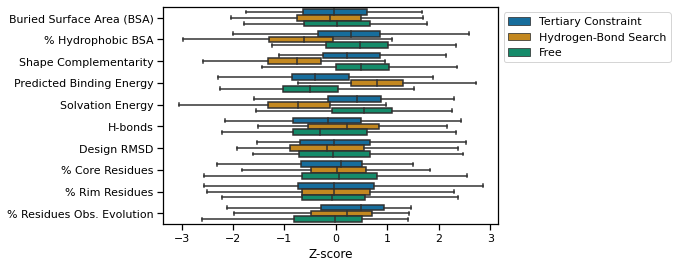

In [50]:
# display(final_bar_df)
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
#     ax.set_xlabel('')
    plt.show()

In [ ]:
## Looking at the pairs of metrics from a handful of some of the influential metrics

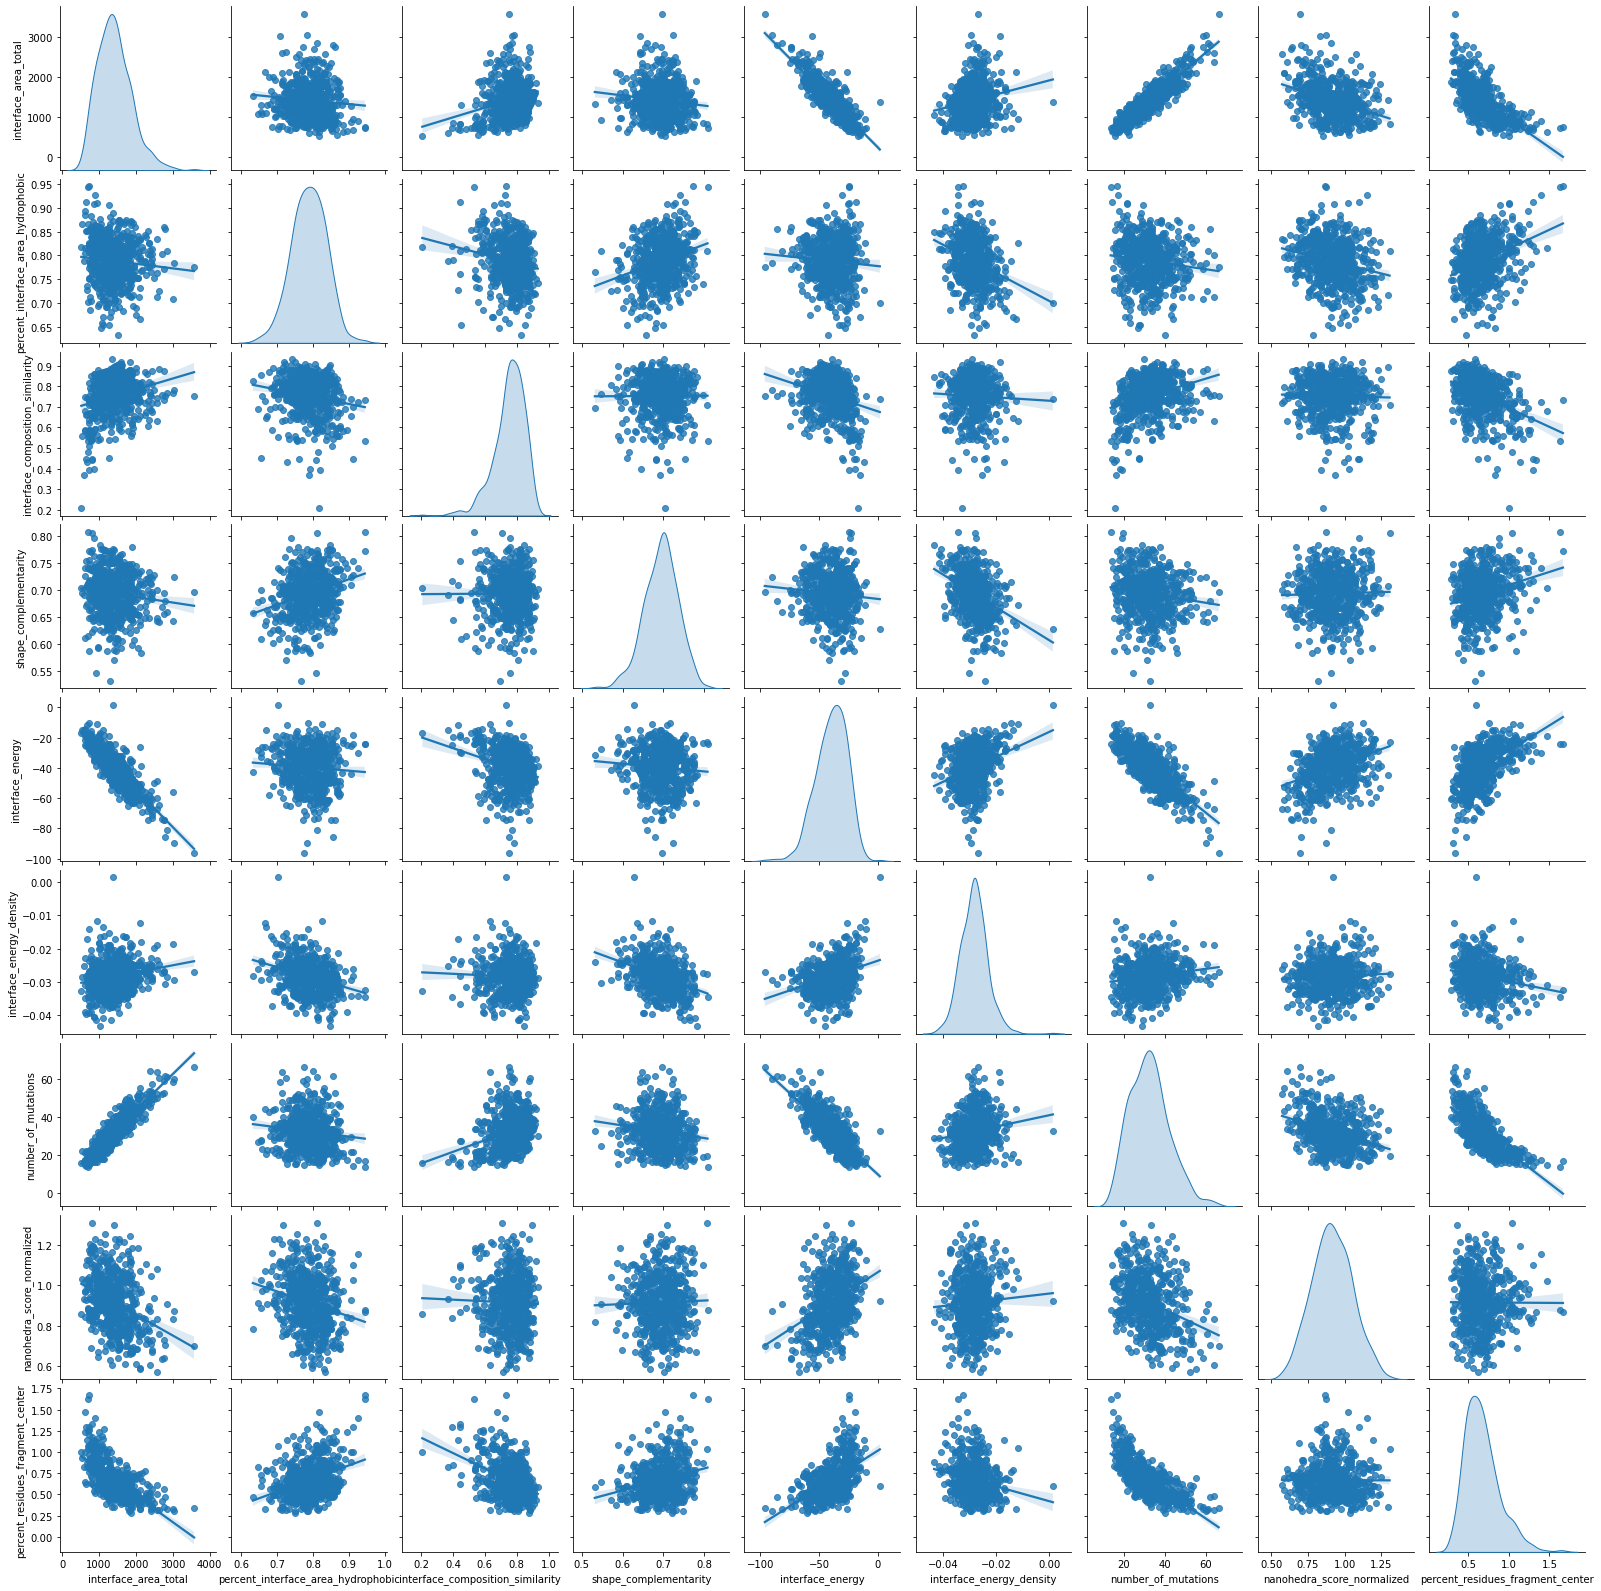

In [46]:
_ = sns.pairplot(df.loc[:, idx_slice['pose', ['mean', 'sequence_design', 'dock'], crackrock_metrics]].droplevel(0, axis=1).droplevel(0, axis=1), kind='reg', diag_kind='kde')

## Filtered DataFrame from my select designs Job. I have a hunch something is wrong with my percent_interface_area_hydrophbic selection given the above results

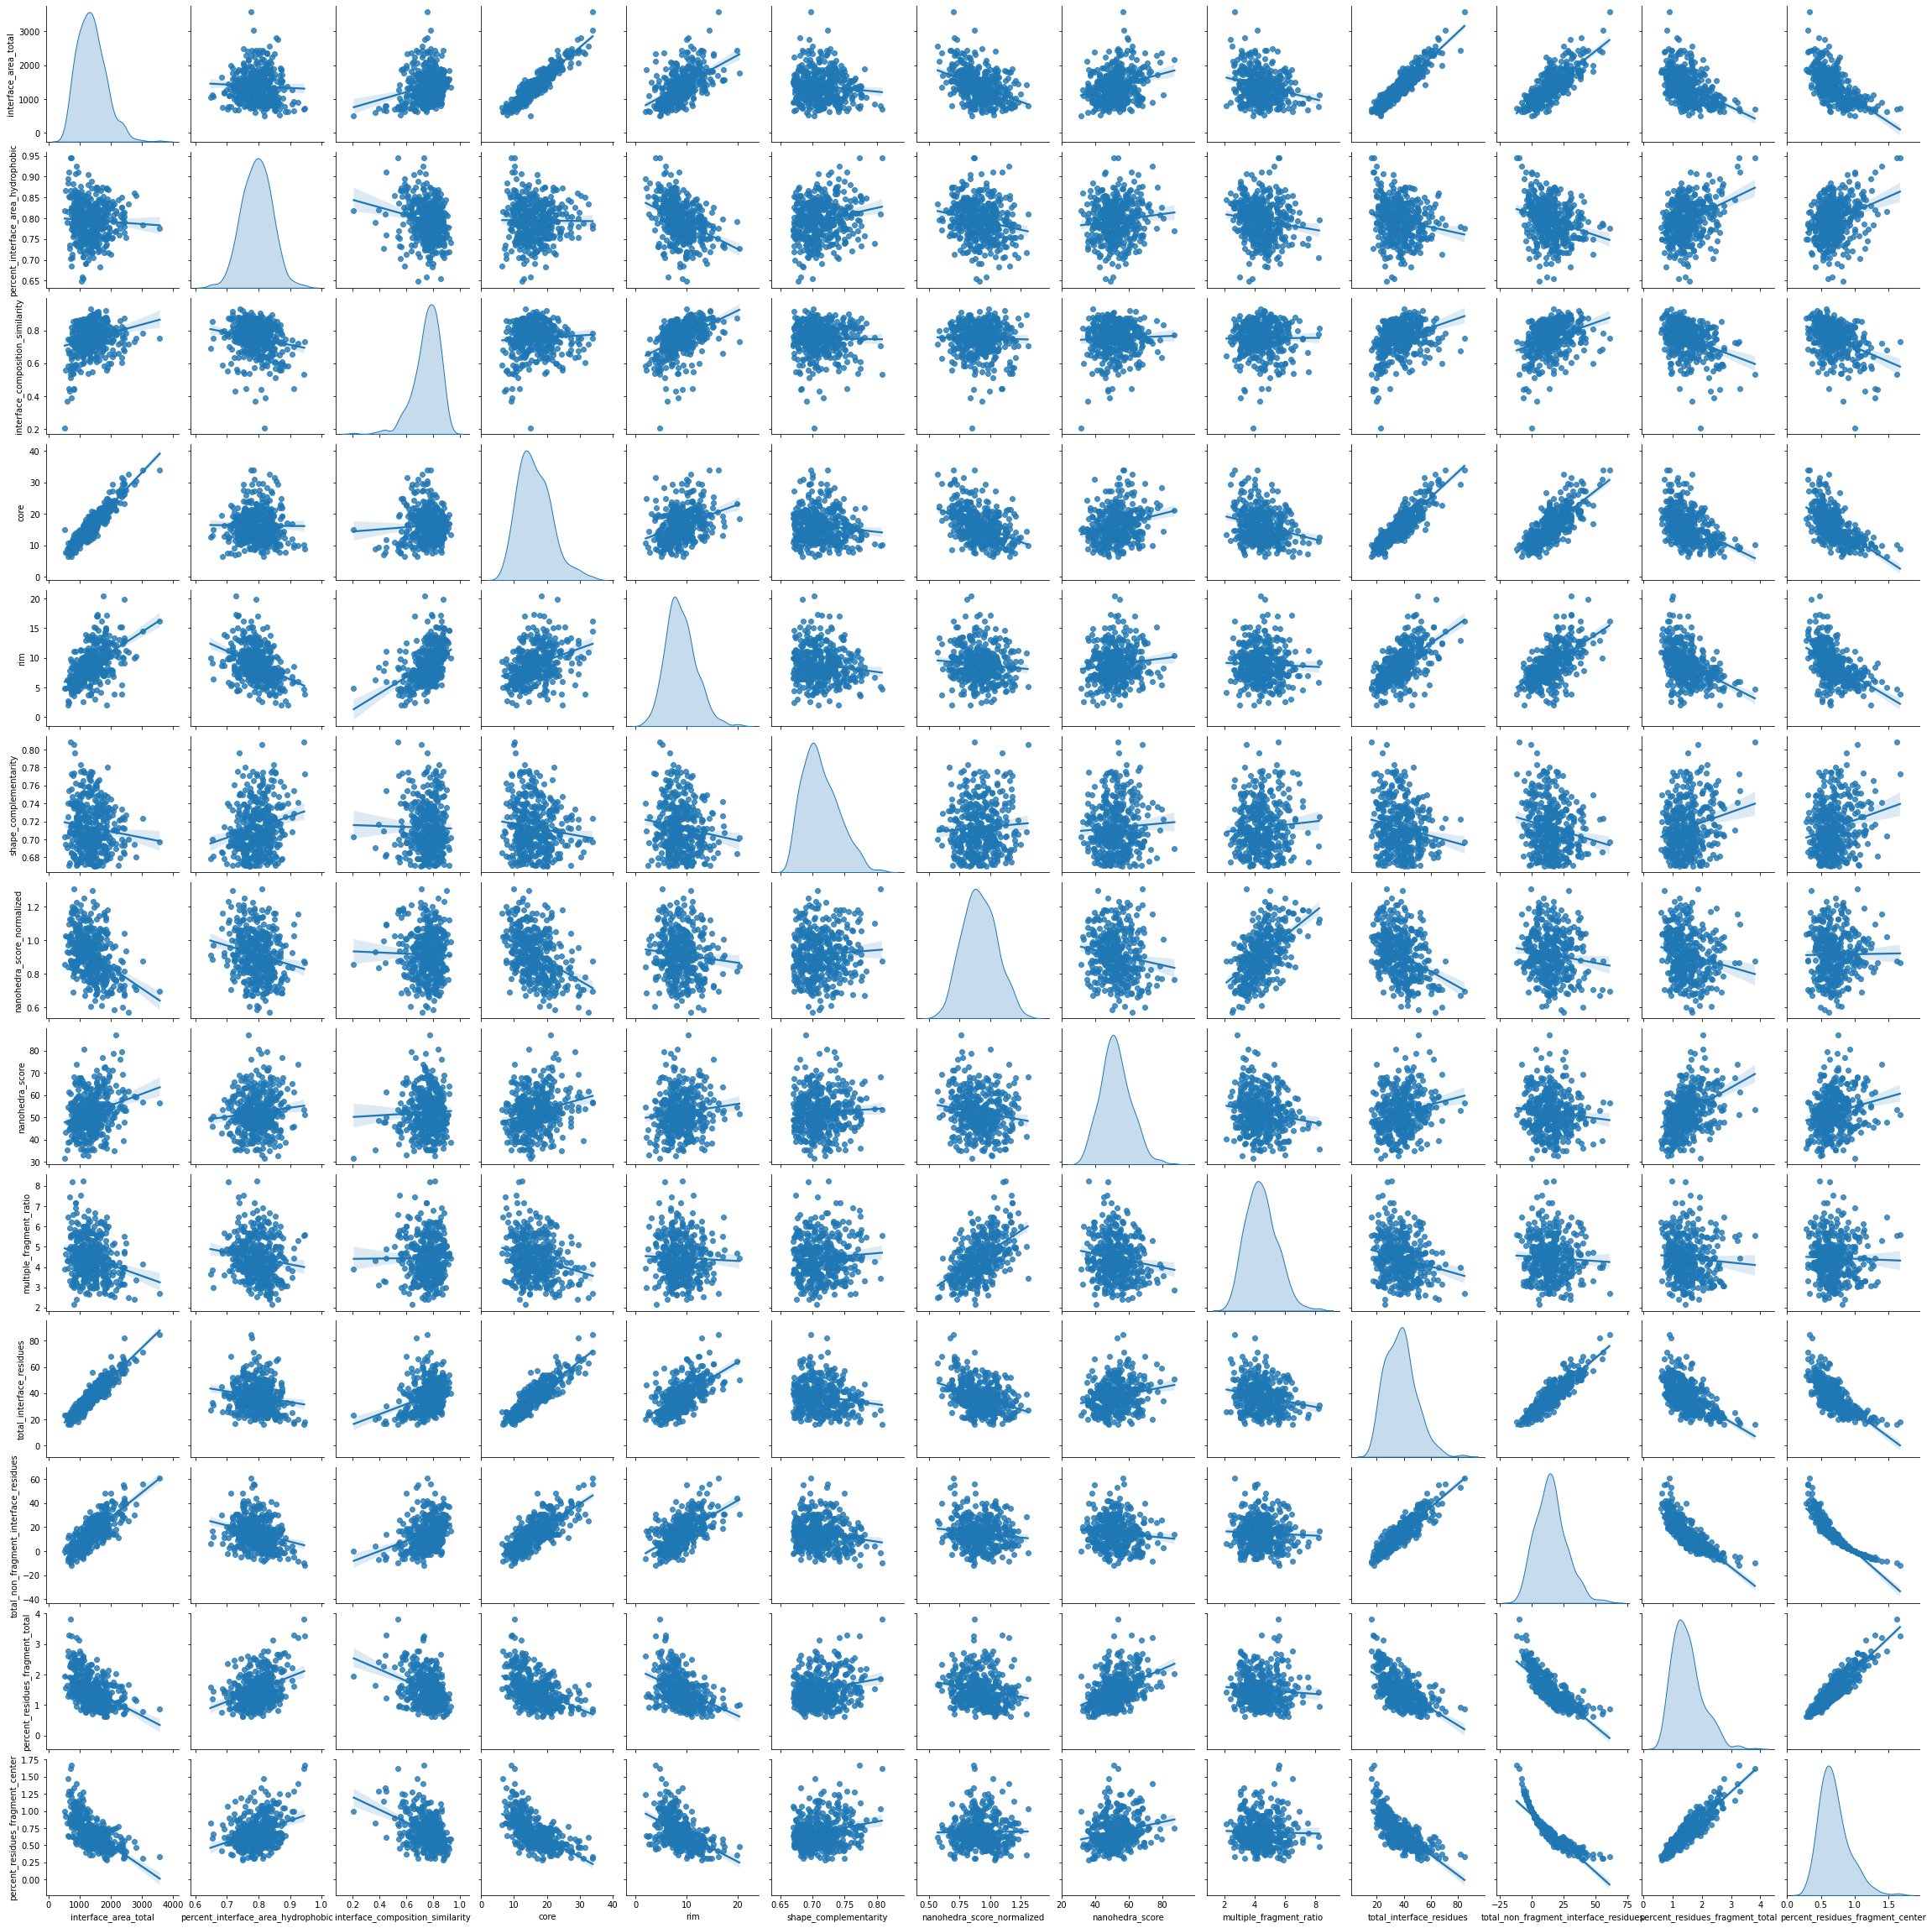

In [24]:
_ = sns.pairplot(filtered_df.loc[:, idx_slice['pose', ['mean', 'sequence_design', 'dock'], crackrock_metrics]].droplevel(0, axis=1).droplevel(0, axis=1), kind='reg', diag_kind='kde')

## Looking into the percent_interface_area_hydrophobic for the design_profile portion only to see if the values for the constrained protocol are any more advantageous than that of Rosetta

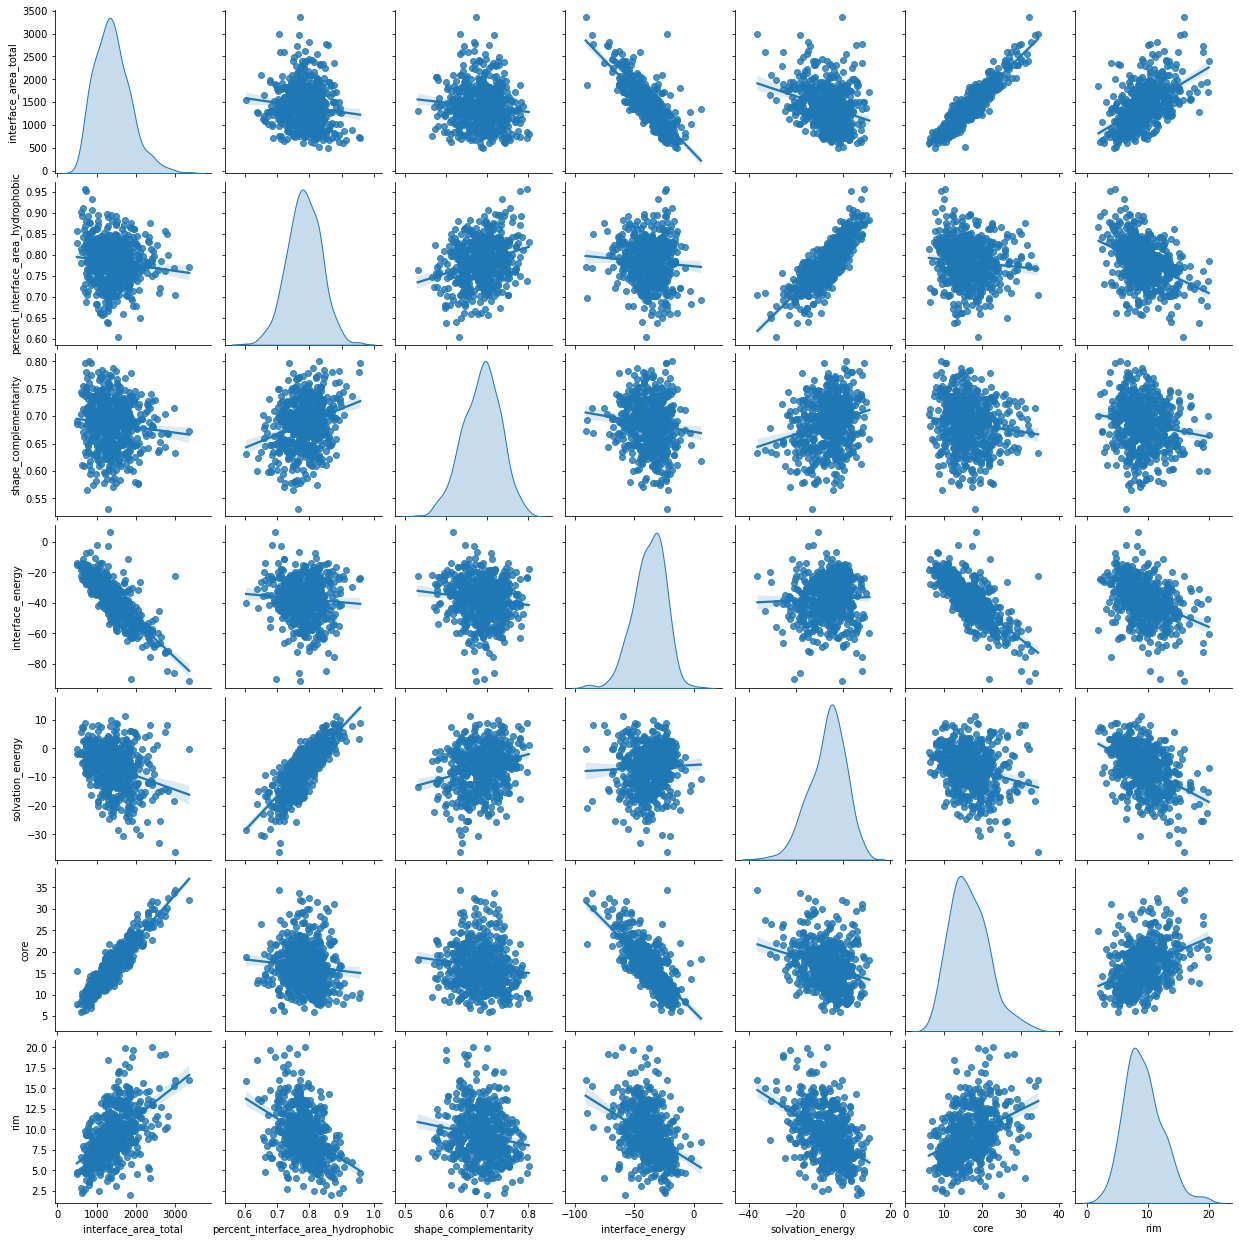

In [40]:
_ = sns.pairplot(df.loc[:, idx_slice['design_profile', ['mean', 'stats'], small_crackrock_metrics]].droplevel(0, axis=1).droplevel(0, axis=1), kind='reg', diag_kind='kde')

In [19]:
# I am using these to find designs that have old, bad designs present as they need to be deleted. 
mean_filters = {'interface_energy': 0, 'interface_energy_unbound': 0}  # >, >
stdev_filters = {'rmsd': 0.1, 'interface_energy_unbound': 60}  # >, >, 

In [50]:
df_descriptors = return_df_feature_descriptors(df)

In [51]:
df_descriptors

descriptors             \
                                                           mean        std   
protocol measure metric                                                      
pose     dock    component_1_c_terminal_orientation    0.294824   0.955552   
                 component_1_max_radius               75.244177  17.118494   
                 component_1_n_terminal_orientation    0.563127   0.826371   
                 component_1_number_of_residues      183.759556  71.099310   
                 component_2_c_terminal_orientation    0.191960   0.981404   
                 component_2_max_radius               75.456900  18.081794   
                 component_2_n_terminal_orientation    0.258924   0.965899   
                 component_2_number_of_residues      197.435763  77.341921   
                 design_dimension                      0.000000   0.000000   
                 interface_b_factor_per_res           20.000000   0.000000   
                 multiple_fragment_ratio               3.524184   1.063585   
                 nanohedra_score                      21.694203   5.098653   
                 nanohedra_score_central               8.460259   3.026140   
                 nanohedra_score_per_res               0.932243   0.139427   
                 number_fragment_residues_central      9.155696   3.148872   
                 number_fragment_residues_total       24.922063   7.210454   
                 percent_fragment_coil                 0.005649   0.023693   
                 percent_fragment_helix                0.992493   0.027880   
                 percent_fragment_strand               0.001858   0.014235   
                 percent_residues_fragment_center      0.337102   0.151532   
                 percent_residues_fragment_total       0.929882   0.418000   
                 total_interface_residues             31.314078  13.971467   
                 unique_fragments                     16.340611   7.869852   

                                                                            \
                                                           min         max   
protocol measure metric                                                      
pose     dock    component_1_c_terminal_orientation  -1.000000    1.000000   
                 component_1_max_radius              39.685598  200.481232   
                 component_1_n_terminal_orientation  -1.000000    1.000000   
                 component_1_number_of_residues      33.000000  366.000000   
                 component_2_c_terminal_orientation  -1.000000    1.000000   
                 component_2_max_radius              39.780388  206.341153   
                 component_2_n_terminal_orientation  -1.000000    1.000000   
                 component_2_number_of_residues      33.000000  384.000000   
                 design_dimension                     0.000000    0.000000   
                 interface_b_factor_per_res          20.000000   20.000000   
                 multiple_fragment_ratio              1.000000    8.666667   
                 nanohedra_score                      9.408189   61.815956   
                 nanohedra_score_central              2.173510   33.925110   
                 nanohedra_score_per_res              0.433220    1.811962   
                 number_fragment_residues_central     3.000000   34.000000   
                 number_fragment_residues_total      11.000000   83.000000   
                 percent_fragment_coil                0.000000    0.857143   
                 percent_fragment_helix               0.142857    1.000000   
                 percent_fragment_strand              0.000000    0.500000   
                 percent_residues_fragment_center     0.035398    2.500000   
                 percent_residues_fragment_total      0.123894    8.500000   
                 total_interface_residues             2.000000  140.000000   
                 unique_fragments                     2.000000   78.00000

In [14]:
unique_protocols = df.columns.get_level_values('protocol').unique().to_list()
unique_protocols.remove('pose')

In [15]:
pose_stats_df = df.loc[:, idx_slice['pose', df.columns.get_level_values(1) != 'std', :]].droplevel(0, axis=1).droplevel(0, axis=1)  # [mean, 'dock', 'seq_design']
pose_std_df = df.loc[:, idx_slice['pose', 'std', :]].droplevel(0, axis=1).droplevel(0, axis=1)  # [mean, 'dock', 'seq_design']

In [18]:
# display(pose_stats_df)
display(pose_std_df)

metric                                contact_count      core  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412       0.203488  2.163696   
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236       0.230222  1.785173   
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29         0.178885  2.164651   
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398        0.187027  1.743828   
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133       0.184627  1.504380   
...                                             ...       ...   
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46        0.200950  2.391775   
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30         0.305016  1.538112   
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214       0.189287  1.631112   
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217       0.289519  1.572795   
4jcu_4i61-DEGEN_1_2-ROT_24_21-tx_177       0.197029  1.976174   

metric                                favor_residue_energy  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412                   0.0   
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236                   0.0   
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29                     0.0   
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398                    0.0   
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133                   0.0   
...                                                    ...   
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46                    0.0   
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30                     0.0   
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214                   0.0   
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217                   0.0   
4jcu_4i61-DEGEN_1_2-ROT_24_21-tx_177                   0.0   

metric                                interaction_energy_complex  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412                    3.959615   
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236                    5.702453   
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29                      5.880629   
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398                     8.918968   
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133                    7.753779   
...                                                          ...   
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46                     5.707967   
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30                      6.661578   
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214                    6.123760   
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217                    3.753921   
4jcu_4i61-DEGEN_1_2-ROT_24_21-tx_177                    6.489030   

metric                                interface_area_hydrophobic  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412                   34.255109   
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236                   97.799996   
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29                     91.077598   
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398                    83.457224   
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133                   59.491457   
...                                                          ...   
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46                    69.952530   
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30                     28.937467   
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214                   93.469203   
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217                   89.834429   
4jcu_4i61-DEGEN_1_2-ROT_24_21-tx_177                   59.252020   

metric                                interface_area_polar  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_412             24.752525   
2gtr_3m6n-DEGEN_1_2-ROT_14_10-tx_236             71.775757   
4kd6_4wcz-DEGEN_1_1-ROT_7_27-tx_29               68.505178   
3jv1_4ogg-DEGEN_1_1-ROT_8_30-tx_398              60.722889   
3hrx_2i9d-DEGEN_1_1-ROT_31_24-tx_133             72.200061   
...                                                    ...   
2gtr_2dj6-DEGEN_1_2-ROT_15_28-tx_46              59.377051   
4xcw_4i61-DEGEN_1_1-ROT_2_38-tx_30               33.469138   
3pac_4n72-DEGEN_1_1-ROT_16_14-tx_214             67.720570   
1pd5_1lu9-DEGEN_1_1-ROT_20_38-tx_217             77.900826   
4jcu_4i61-DEGEN_1_2-ROT_24_21-tx_177             38.710078   

metric                                interface_area_total  \
3tcr_2zhy-DEGEN_1_1-ROT_17_28-tx_

## Filter on metrics in the dataframe 
These metrics were pulled from Janin et al. 2008 as the set of crystal interface identifiers.  
You can define other identifiers in a similar {key: value} pairs

In [2]:
crystal_means = {'int_area_total': 570, 'shape_complementarity': 0.63, 'number_hbonds': 5}
other_means = {'total_interface_residues': 52, 'nanohedra_score_central': 15, 'multiple_fragment_ratio': 3.52}

Modify 'design_filters' variable to set your filters of choice

In [22]:
design_filters = mean_filters
filter_df = pose_stats_df

In [24]:
print('Starting designs = %d' % len(filter_df))
filtered_indices = {}
for metric in design_filters:
    filtered_indices[metric] = set(filter_df[filter_df[metric] >= design_filters[metric]].index.to_list())
    print('Number of designs passing %s = %d' % (metric, len(filtered_indices[metric])))

Starting designs = 543
Number of designs passing interface_energy = 7
Number of designs passing interface_energy_unbound = 463


In [19]:
final_indices = index_intersection(filtered_indices)
print('Final number of designs passing all metrics is %d' % len(final_indices))

Final number of designs passing all metrics is 198


In [26]:
metric = 'interface_energy_unbound'
filter_df.loc[filtered_indices[metric], metric].sort_values()[50:60]

3wfv_4o8u-DEGEN_1_1-ROT_6_39-tx_309     57.443600
4kd6_3cp1-DEGEN_1_2-ROT_6_38-tx_249     57.709513
2gtr_1nq3-DEGEN_1_2-ROT_38_22-tx_140    57.994131
4wcz_1o5j-DEGEN_1_2-ROT_22_6-tx_70      58.609585
3tcr_1ekq-DEGEN_1_1-ROT_35_16-tx_272    63.343506
4o8u_3zmf-DEGEN_1_1-ROT_20_21-tx_283    64.735958
3oi9_3qv0-DEGEN_1_1-ROT_1_16-tx_38      65.607726
3jv1_3hrx-DEGEN_1_2-ROT_12_15-tx_388    66.065833
3wfv_2gtr-DEGEN_1_2-ROT_7_2-tx_412      67.940505
4kd6_2dj6-DEGEN_1_2-ROT_2_26-tx_14      69.705704
Name: interface_energy_unbound, dtype: float64

3pac_3q98/DEGEN_1_1/ROT_33_39/tx_288/designs/ has a number of MSE near the interface which are missing density. I can't imagine how this is messing up the calculation...
Looking at the residue_df alone, the deltas are astronomical for many of the residues. How poorly do they look when unbound?


In [21]:
filtered_df = df.loc[final_indices, :]
display(filtered_df)

In [22]:
num_obs_df = filtered_df.loc[:, idx_slice[:, ['stats'], ['observations']]].droplevel(1, axis=1)

In [23]:
stats_df = filtered_df.loc[:, idx_slice[:, ['stats'], ['observations']]].droplevel(1, axis=1)

### Looking into the contributions of different metrics to the filtered poses

In [24]:
filtered_pose_df = filtered_df.loc[:, idx_slice['pose', df.columns.get_level_values(1) != std, :]].droplevel(1, axis=1).droplevel(0, axis=1)
filtered_pose_df.drop('symmetry', axis=1, inplace=True, errors='ignore')

In [25]:
display(filtered_pose_df)

metric                                average_fragment_z_score  \
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339                    0.876481   
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946                    0.736054   
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296                    0.777590   
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935                   0.655106   
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123                   0.792879   
...                                                        ...   
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467                    0.743833   
3zo8_4j3z-DEGEN_1_1-ROT_8_1-tx_295                    0.792705   
3wfv_2ap6-DEGEN_1_1-ROT_13_1-tx_855                   0.739884   
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_357                    0.927689   
2i9d_3aff-DEGEN_1_1-ROT_15_1-tx_1211                  0.659982   

metric                                interface_b_factor_per_res  \
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339                          20.0   
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946                          20.0   
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296                          20.0   
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935                         20.0   
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123                         20.0   
...                                                          ...   
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467                          20.0   
3zo8_4j3z-DEGEN_1_1-ROT_8_1-tx_295                          20.0   
3wfv_2ap6-DEGEN_1_1-ROT_13_1-tx_855                         20.0   
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_357                          20.0   
2i9d_3aff-DEGEN_1_1-ROT_15_1-tx_1211                        20.0   

metric                                nanohedra_score  observations  \
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339           4.580459            58   
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946           4.903429            56   
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296           1.286024            56   
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935          6.644818            62   
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123          7.940886            62   
...                                               ...           ...   
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467           8.487259            55   
3zo8_4j3z-DEGEN_1_1-ROT_8_1-tx_295           5.103849            60   
3wfv_2ap6-DEGEN_1_1-ROT_13_1-tx_855          5.591035            63   
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_357           5.800009            66   
2i9d_3aff-DEGEN_1_1-ROT_15_1-tx_1211         7.057863            63   

metric                                percent_fragment  unique_fragments  \
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339            0.640000                 4   
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946            0.341463                 3   
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296            0.148148                 1   
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935           0.619048                 4   
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123           0.466667                 6   
...                                                ...               ...   
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467            0.857143                 6   
3zo8_4j3z-DEGEN_1_1-ROT_8_1-tx_295            0.419355                 4   
3wfv_2ap6-DEGEN_1_1-ROT_13_1-tx_855           0.823529                 4   
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_357            0.656250                 4   
2i9d_3aff-DEGEN_1_1-ROT_15_1-tx_1211          0.406250                 4   

metric                                buns_heavy_total  buns_hpol_total  \
4f47_4grd-DEGEN_1_1-ROT_9_1-tx_339            0.035714         0.000000   
4f47_4ast-DEGEN_1_1-ROT_5_1-tx_946            3.166667         2.425926   
4f47_4grd-DEGEN_1_1-ROT_8_1-tx_296            0.833333         0.629630   
2q0t_1bkh-DEGEN_1_1-ROT_16_1-tx_935           0.466667         0.416667   
1o5j_4grd-DEGEN_1_1-ROT_39_1-tx_123           1.850000         1.300000   
...                                                ...              ...   
1zoi_4ast-DEGEN_1_2-ROT_2_1-tx_467            0.188679         0.226415   
3zo8_4j3z-DEGEN_1_1-ROT_

In [26]:
pose_range_s = filtered_pose_df.max() - filtered_pose_df.min()
pose_mean_s = filtered_pose_df.mean()
pose_std_s = filtered_pose_df.std()
pose_sum_stats_df = pd.DataFrame()
measures = {'range': pose_range_s, 'mean': pose_mean_s, 'std': pose_std_s}
for n in measures:
    pose_sum_stats_df[n] = measures[n]
pose_sum_stats_df = pd.concat([pose_sum_stats_df], keys=['filtered'], axis=1)

In [27]:
display(pose_sum_stats_df)

## Get all protocol mean/stats metrics
This will only work for designs after sequence design has been performed

In [32]:
# full_protocol_df = df.loc[:, idx_slice[df.columns.get_level_values(0) != 'pose', 
#                                  [df.columns.get_level_values(1) == mean, df.columns.get_level_values(1) == 'stats'],
#                                  :]].droplevel(1, axis=1)
mean_protocol_df = df.loc[:, idx_slice[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_protocol_df = df.loc[:, idx_slice[df.columns.get_level_values(0) != 'pose', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
design_protocols_df = pd.merge(mean_protocol_df, stats_protocol_df, left_index=True, right_index=True)

In [33]:
# full_protocol_df = df.loc[:, idx_slice[df.columns.get_level_values(0) == 'pose', df.columns.get_level_values(1) != 'stdev', :]].droplevel(1, axis=1)  # gets dock as well

In [34]:
limited_protocols = list(set(df.columns.get_level_values(0).to_list()) - {'pose', 'consensus'})

In [35]:
mean_no_constraint_df = df.loc[:, idx_slice[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == mean, :]].droplevel(1, axis=1)
stats_no_constraint_df = df.loc[:, idx_slice[df.columns.get_level_values(0) == 'no_constraint', df.columns.get_level_values(1) == 'stats', :]].droplevel(1, axis=1)
no_constraint_protocol_df = pd.merge(mean_no_constraint_df, stats_no_constraint_df, left_index=True, right_index=True)

In [36]:
# protocol_df = mean_protocol_df  # protocols only looking at mean
# protocol_df = stats_protocol_df  # protocols only looking at stats

In [81]:
pose_df = df.loc[:, idx_slice['pose', df.columns.get_level_values(1) != std, :]].droplevel(1, axis=1) # .droplevel(0, axis=1)
design_profile_df = df.loc[:, idx_slice['design_profile', df.columns.get_level_values(1) != std, :]].droplevel(1, axis=1) # .droplevel(0, axis=1)

# Protocol Switch point for checking graphs below

In [82]:
# All df have two column levels
# protocol_df = pose_df  # all pose metrics, no sd
protocol_df = design_profile_df  # all design_profile metrics, no sd
# protocol_df = design_protocols_df  # all pose, protocol metrics, no sd
# protocol_df = xtal_pose_df  # poses matching crystalline parameters, no sd
# protocol_df = xtal_pose_filtered_df  # same as above, protocol similarity metric appended
# protocol_df = limited_protocol_df  # subset of desired protocols looking at mean and only limit_to_profile

In [83]:
display(protocol_df.corr(method='spearman'))

protocol                                        design_profile  \
metric                                           no_constraint   
protocol       metric                                            
design_profile no_constraint                          1.000000   
               HBNet_NumUnsatHpol                          NaN   
               HBNet_Saturation                            NaN   
               HBNet_Score                                 NaN   
               buns_1_unbound                         0.203420   
...                                                        ...   
               divergence_fragment_per_residue        0.307020   
               divergence_interface_per_residue      -0.026296   
               no_constraint                          0.360201   
               refine                                -0.189487   
               no_constraint                          0.029402   

protocol                                                            \
metric                                          HBNet_NumUnsatHpol   
protocol       metric                                                
design_profile no_constraint                                   NaN   
               HBNet_NumUnsatHpol                              NaN   
               HBNet_Saturation                                NaN   
               HBNet_Score                                     NaN   
               buns_1_unbound                                  NaN   
...                                                            ...   
               divergence_fragment_per_residue                 NaN   
               divergence_interface_per_residue                NaN   
               no_constraint                                   NaN   
               refine                                          NaN   
               no_constraint                                   NaN   

protocol                                                                      \
metric                                          HBNet_Saturation HBNet_Score   
protocol       metric                                                          
design_profile no_constraint                                 NaN         NaN   
               HBNet_NumUnsatHpol                            NaN         NaN   
               HBNet_Saturation                              NaN         NaN   
               HBNet_Score                                   NaN         NaN   
               buns_1_unbound                                NaN         NaN   
...                                                          ...         ...   
               divergence_fragment_per_residue               NaN         NaN   
               divergence_interface_per_residue              NaN         NaN   
               no_constraint                                 NaN         NaN   
               refine                                        NaN         NaN   
               no_constraint                                 NaN         NaN   

protocol                                                        \
metric                                          buns_1_unbound   
protocol       metric                                            
design_profile no_constraint                          0.203420   
               HBNet_NumUnsatHpol                          NaN   
               HBNet_Saturation                            NaN   
               HBNet_Score                                 NaN   
               buns_1_unbound                         1.000000   
...                                                        ...   
               divergence_fragment_per_residue        0.024841   
               divergence_interface_per_residue       0.077219   
               no_constraint                         -0.038483   
               refine                                 0.244630   
               no_constraint                         -0.042499   

protocol                                        

In [84]:
subset_df = protocol_df.droplevel(0, axis=1)
# display(subset_df)

Edit these metrics to look at the correlation between specific metrics you are interested in

In [89]:
# metrics_of_interest = ['nanohedra_score', 'unique_fragments', 'protocol_energy_distance_sum', 'protocol_similarity_sum', 'protocol_seq_distance_sum',
#                        'int_separation', 'int_connectivity_A', 'int_connectivity_B', 'number_hbonds', 'contact_count', 
#                        'int_area_total', 'int_area_polar', 'int_area_hydrophobic', 'total_interface_residues', 
#                        'core', 'rim', 'support', 'percent_support', 'percent_core', 'percent_rim', 'int_composition_diff',
#                        'int_energy_res_summary_delta', 'solvation_energy', 'interaction_energy_complex', 'percent_fragment', 'observed_combined', 'observed_evolution', 
#                        'observed_fragment', 'divergence_evolution_per_res', 'divergence_fragment_per_res', 'divergence_combined_per_res', 'divergence_interface_per_res', 
#                        'shape_complementarity']
metrics_of_interest = \
[
#  'multiple_fragment_ratio', 'nanohedra_score', 'nanohedra_score_center',
#  'nanohedra_score_center_normalized', 'nanohedra_score_normalized',
#  'protocol_energy_distance_sum', 'protocol_sequence_distance_sum', 'protocol_similarity_sum',
#  'number_fragment_residues_center', 'number_fragment_residues_total',
#  'number_of_fragments', 
 'observations', 
 'interface_separation', 'interface_connectivity_1', 'interface_connectivity_2',
 'number_hbonds', 'contact_count', 
 'number_of_mutations', # 'total_interface_residues', 'total_non_fragment_interface_residues',
 'interface_area_hydrophobic', 'interface_area_polar', 'interface_area_total',
 'interface_bound_activation_energy',
 'interface_composition_similarity',
 'percent_interface_area_hydrophobic', 'percent_interface_area_polar',
 'core', 'rim', 'support', 'percent_core', 'percent_rim', 'percent_support', 
 'rmsd_complex',]
#  'rosetta_reference_energy', 'solvation_energy', 'interface_energy', 'interface_energy_density', 'interaction_energy_complex', 
#  'percent_fragment', 'percent_residues_fragment_center', 'percent_residues_fragment_total',
#  'observed_design', 'observed_evolution', 'observed_fragment', 
#  'divergence_evolution_per_residue', 'divergence_fragment_per_residue', 'divergence_design_per_residue', 'divergence_interface_per_residue',
#  'shape_complementarity']

<AxesSubplot:xlabel='metric', ylabel='metric'>

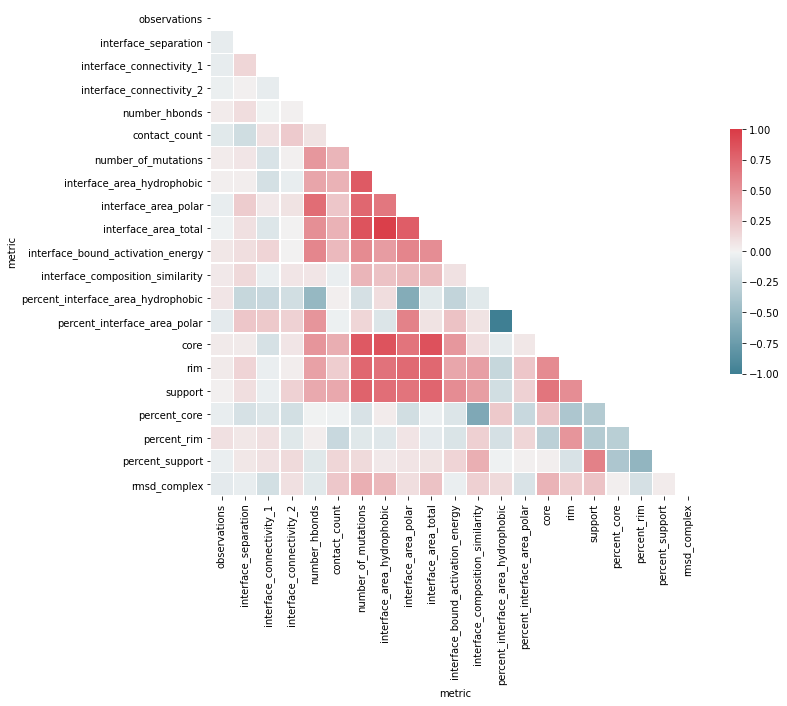

In [90]:
corr_df = subset_df[metrics_of_interest]
corr = corr_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Here you could plot pairs of correlated variables
add the pairs as a tuple in the metric pairs list

-0.029434861957629836

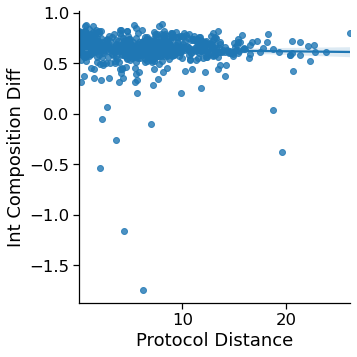

-0.185024865705374

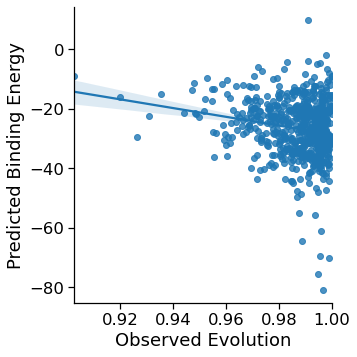

-0.05190526664245933

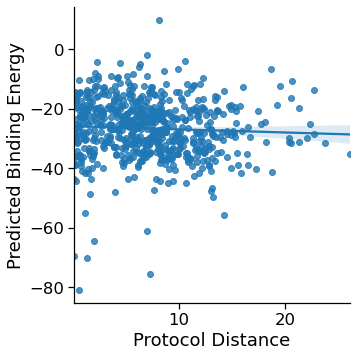

0.21795811793523265

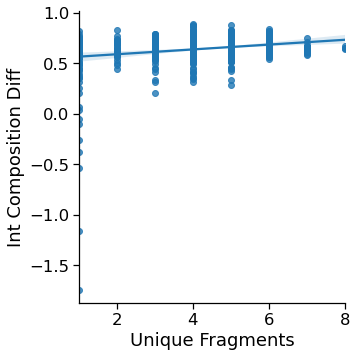

0.2398782586755383

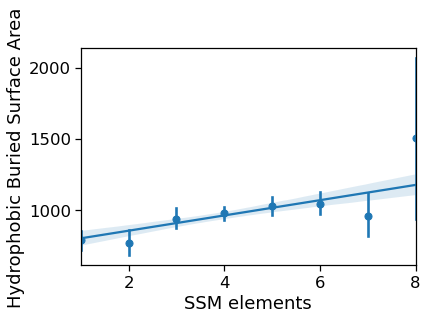

0.251007627103954

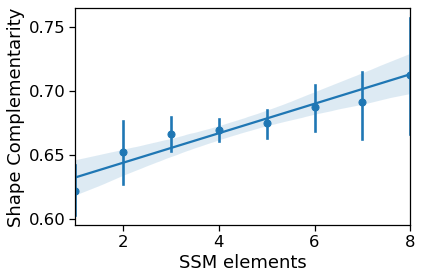

-0.30176420455599384

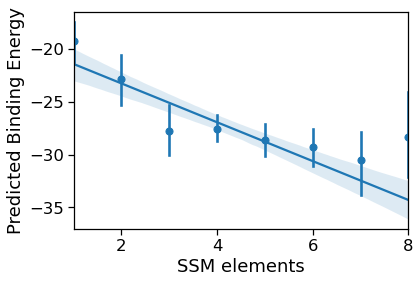

In [42]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [
#                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
#                 ('interaction_energy_complex', 'int_energy_res_summary_delta'),
#                 ('divergence_interface_per_res', 'contact_count'), 
#                 ('shape_complementarity', 'int_separation'),
#                 ('percent_support', 'int_composition_diff'),
#                 ('percent_rim', 'int_composition_diff'),
#                 ('percent_core', 'int_composition_diff'),
#                 ('int_composition_diff', 'int_energy_res_summary_delta'),
                ('protocol_energy_distance_sum', 'int_composition_diff'),
                ('observed_evolution', 'int_energy_res_summary_delta'),
                ('protocol_energy_distance_sum', 'int_energy_res_summary_delta'),
                ('unique_fragments', 'int_composition_diff')
#                 ('observed_evolution', 'protocol_energy_distance_sum'),
#                 ('observed_evolution', 'protocol_seq_distance_sum'),
#                 ('percent_fragment', 'int_area_hydrophobic'),
                ]
bar_plot_pairs = [
                  ('unique_fragments', 'int_area_hydrophobic'),
                  ('unique_fragments', 'shape_complementarity'),
                  ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
                 ]
# for x, y in combinations(metric_pairs):
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in metric_pairs:
        display(subset_df[x].corr(subset_df[y]))
        ax = sns.lmplot(x=x, y=y, data=subset_df)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        if x == 'protocol_energy_distance_sum':
            x = 'protocol_distance'
        ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
        plt.show()
with sns.plotting_context("notebook", font_scale=1.5):
    for x, y in bar_plot_pairs:
        display(subset_df[x].corr(subset_df[y]))
    #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#         ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        ax = sns.regplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
        if y == 'int_energy_res_summary_delta':
            y = 'predicted_binding_energy'
        elif y == 'int_area_hydrophobic':
            y = 'hydrophobic_buried_surface_area'
        ax.set(xlabel='SSM elements', ylabel=' '.join(y.split('_')).title())  # format into a fancier axis title
        plt.show()
# sns.pairplot(subset_df, x_vars=['shape_complementarity', 'int_energy_res_summary_delta'], y_vars=['unique_fragments'],
#              height=5, aspect=.8, kind="reg")
# sns.pairplot(subset_df, y_vars=['shape_complementarity', 'int_energy_res_summary_delta'], x_vars=['unique_fragments'],
#             aspect=.8, kind="reg") # height=5
# sns.lmplot(x=y, y=x, data=subset_df, x_estimator=np.mean, col='vars', hue='vars')

0.5358091674094778

0.8198734978002182

-0.4348166451353058

-0.9396953085946905

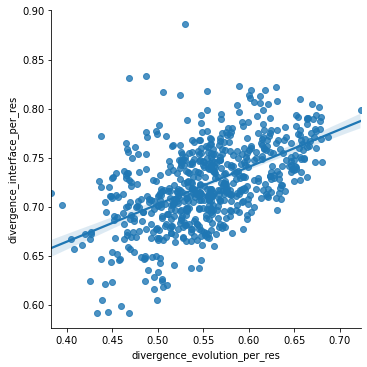

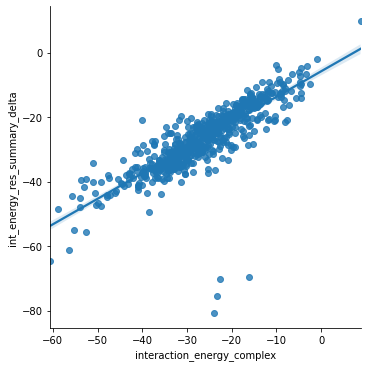

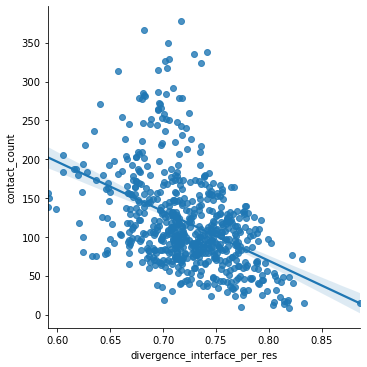

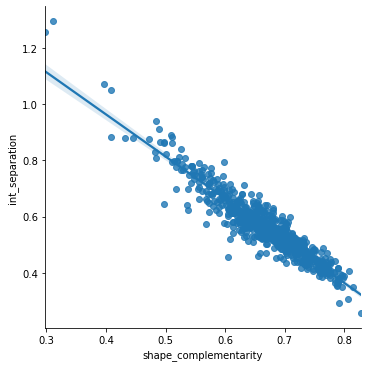

In [43]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
subset_df = protocol_df.droplevel(0, axis=1)
metric_pairs = [('divergence_evolution_per_res', 'divergence_interface_per_res'), 
                ('interaction_energy_complex', 'int_energy_res_summary_delta'),
                ('divergence_interface_per_res', 'contact_count'), 
                ('shape_complementarity', 'int_separation'), ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    sns.lmplot(x=x, y=y, data=subset_df)

In [44]:
metrics_of_interest = {'observed_evolution': '% Residues Obs. Evol.',
                       'int_area_total': 'Buried Surface Area (BSA)',
                       'shape_complementarity': 'Shape Complementarity',
                       'int_energy_res_summary_delta': 'Predicted Binding Energy', 
#                        'contact_count': 'Carbon-Carbon Contacts', 
                       'percent_int_area_hydrophobic': 'Hydrophobic BSA',
                       'number_hbonds': 'H-bonds',
                       'buns_total': 'Buried Unsat. H-bonds',
#                        'core', 'rim', 'support']  #'interaction_energy_complex', 'int_area_hydrophobic',
#                              'int_area_polar', 'int_area_total']
                      }

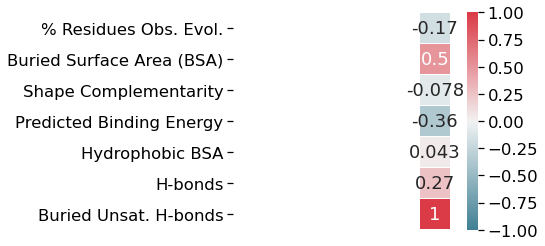

In [46]:
subset_df = protocol_df.droplevel(0, axis=1)
subset_df = subset_df['protocol_energy_distance_sum']
protocol_energy = {'protocol_energy_distance_sum': 'Protocol Distance'}
metrics_of_interest2 = metrics_of_interest.copy()
metrics_of_interest2.update(protocol_energy)
constraint_corr_df = pd.merge(no_constraint_protocol_df.droplevel(0, axis=1), subset_df, left_index=True, right_index=True)
subset_constraint_corr_df = constraint_corr_df[list(metrics_of_interest.keys())]  # + list(protocol_energy.keys())
subset_constraint_corr_df = subset_constraint_corr_df.rename(columns=metrics_of_interest)
corr = subset_constraint_corr_df.corr(method='spearman')
# mask = np.ones_like((len(corr), len(corr) - 1), dtype=np.bool)

# Generate a mask to display only correlations of interest
mask = np.ones_like(corr, dtype=np.bool)
# display(mask)
for i, row in enumerate(mask):
    mask[i][-1] = False
# display(mask)
# display(mask[: ,-1])
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Plot
with sns.plotting_context("notebook", font_scale=1.5):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, # cbar_kws={"shrink": .5},
                annot=True, xticklabels=False)

-0.04896870293552273

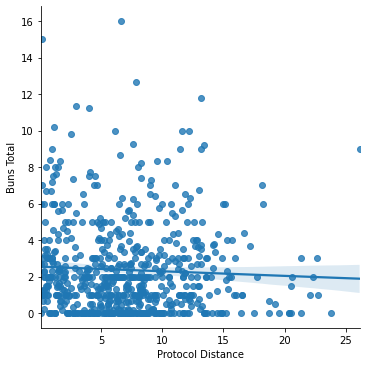

0.029807015989423515

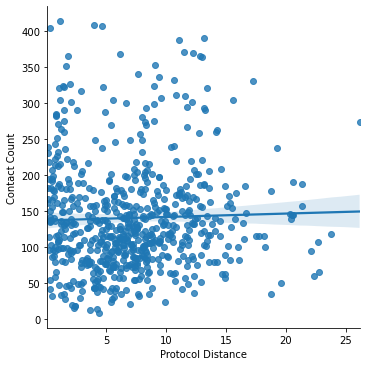

0.1093822884764262

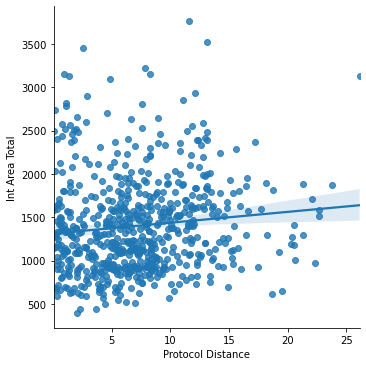

-0.11056487163124432

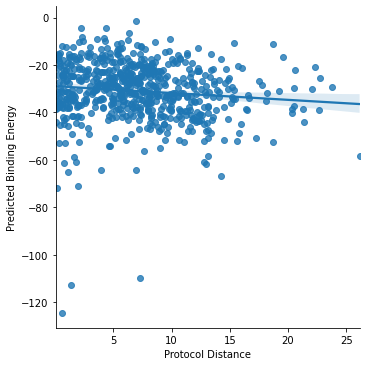

-0.10115573712066464

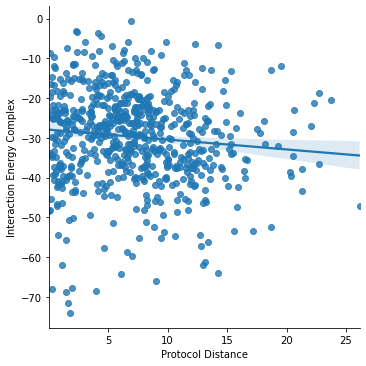

0.0767432887230824

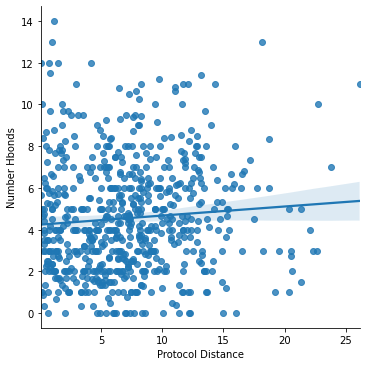

0.05537641329509701

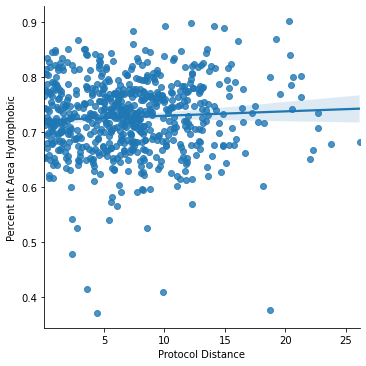

0.06912498379015046

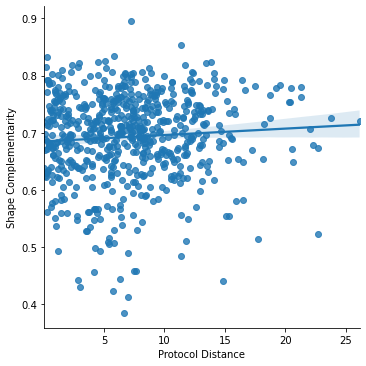

0.06575461634767506

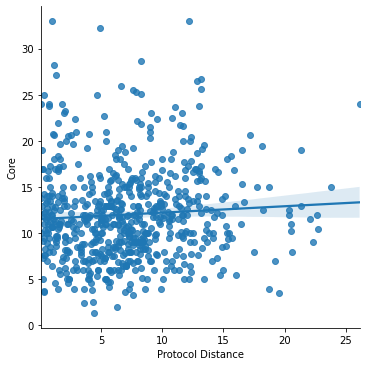

-0.009475537181021105

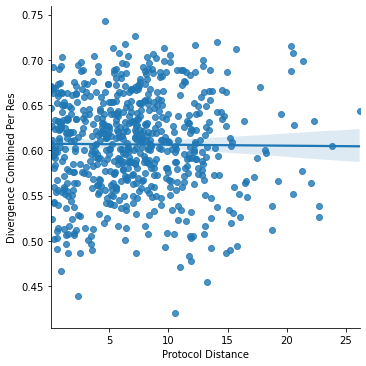

-0.023026973333753604

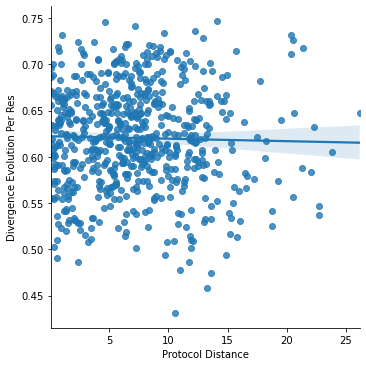

-0.03461434833483293

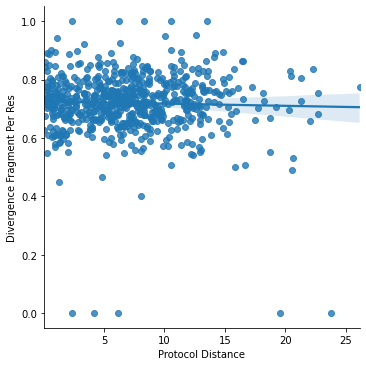

0.13714494644246372

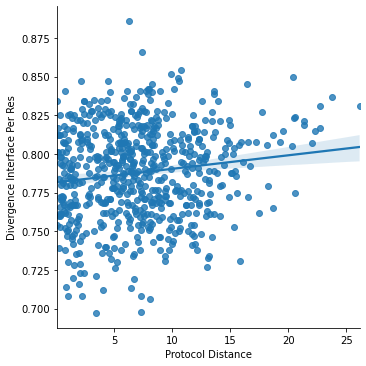

-0.06785635968687807

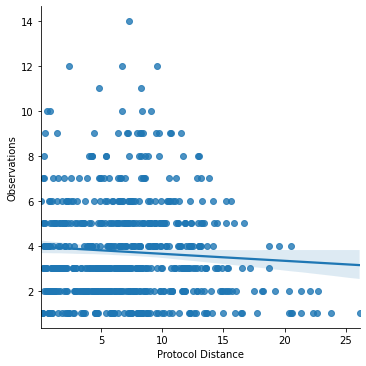

-0.06390743279626111

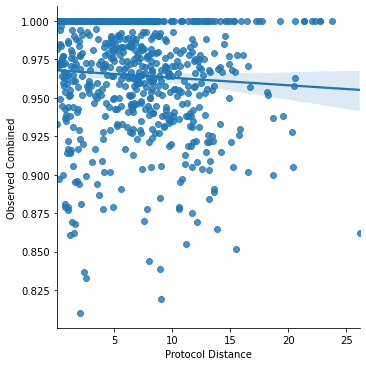

-0.1111422783025701

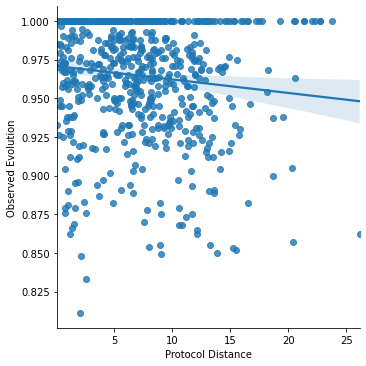

0.03497266934384523

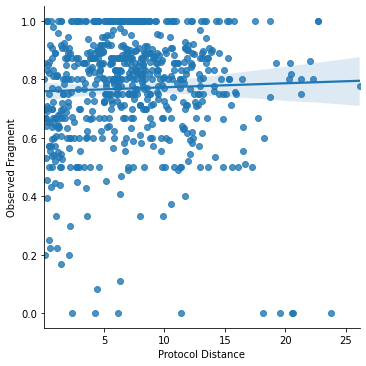

0.052375776552585296

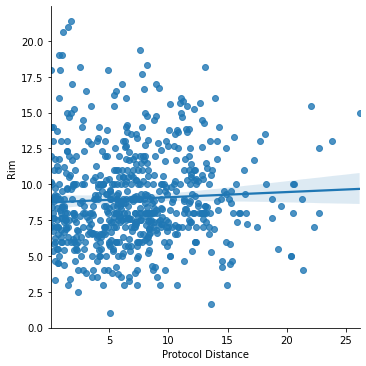

-0.01910454984823349

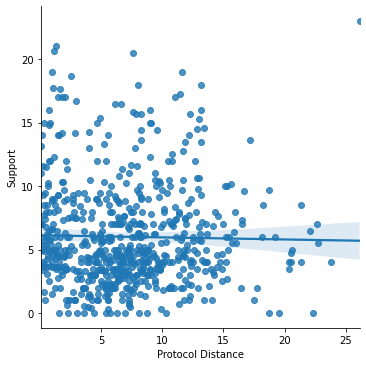

1.0

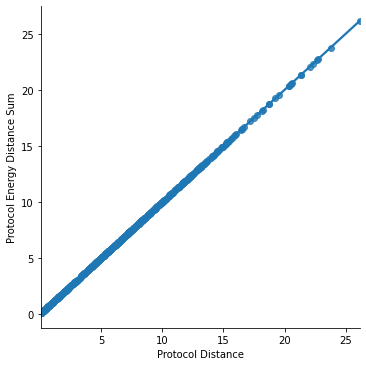

In [47]:
# corr_df = protocol_df.droplevel(0, axis=1)
# display(corr_df)
# subset_df = protocol_df.droplevel(0, axis=1)
# metric_pairs = [
# #                 ('divergence_evolution_per_res', 'divergence_interface_per_res'), 
# #                 ('interaction_energy_complex', 'int_energy_res_summary_delta'),
# #                 ('divergence_interface_per_res', 'contact_count'), 
# #                 ('shape_complementarity', 'int_separation'),
# #                 ('percent_support', 'int_composition_diff'),
# #                 ('percent_rim', 'int_composition_diff'),
# #                 ('percent_core', 'int_composition_diff'),
# #                 ('int_composition_diff', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_composition_diff'),
#                 ('observed_evolution', 'int_energy_res_summary_delta'),
#                 ('protocol_energy_distance_sum', 'int_energy_res_summary_delta'),
#                 ('unique_fragments', 'int_composition_diff')
# #                 ('observed_evolution', 'protocol_energy_distance_sum'),
# #                 ('observed_evolution', 'protocol_seq_distance_sum'),
# #                 ('percent_fragment', 'int_area_hydrophobic'),
#                 ]
subset_df = constraint_corr_df
from itertools import repeat
metric_pairs = zip(repeat('protocol_energy_distance_sum'), constraint_corr_df.columns.to_list())
# bar_plot_pairs = [
#                   ('unique_fragments', 'int_area_hydrophobic'),
#                   ('unique_fragments', 'shape_complementarity'),
#                   ('unique_fragments', 'int_energy_res_summary_delta'),
#                   ('unique_fragments', 'int_composition_diff')
#                  ]
# for x, y in combinations(metric_pairs):
for x, y in metric_pairs:
    display(subset_df[x].corr(subset_df[y]))
    ax = sns.lmplot(x=x, y=y, data=subset_df)
    if y == 'int_energy_res_summary_delta':
        y = 'predicted_binding_energy'
    if x == 'protocol_energy_distance_sum':
        x = 'protocol_distance'
    ax.set(xlabel=' '.join(x.split('_')).title(), ylabel=' '.join(y.split('_')).title())
    plt.show()
# for x, y in bar_plot_pairs:
#     display(subset_df[x].corr(subset_df[y]))
# #     ax = sns.catplot(x=x, y=y, kind='violin', data=subset_df)
#     ax = sns.lmplot(x=x, y=y, data=subset_df, x_estimator=np.mean)
#     if y == 'int_energy_res_summary_delta':
#         y = 'predicted_binding_energy'
#     elif y == 'int_area_hydrophobic':
#         y = 'hydrophobic_buried_surface_area'
#     ax.set(xlabel='SSC elements', ylabel=' '.join(y.split('_')).title())
#     plt.show()

In [48]:
protocols_of_interest_freeVnot = {'no_constraint': 'Free', 'combo_profile': 'Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest_all = {'no_constraint': 'Free', 'combo_profile': 'Constraint', 'limit_to_profile': 'Latent Evolution', 'favor_profile': 'Weighted Constraint'}  # 'limit_to_profile', 'consensus',
protocols_of_interest = protocols_of_interest_freeVnot

## Reformat the data to pull specific columns and make a vertically stacked dataframe to produce Bar graphs which have a normalized z-value and are thus comparable across different scalar ranges

In [49]:
# from sklearn.preprocessing import StandardScaler

# normalized_df = design_protocols_df.subtract(design_protocols_df.min())

# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(design_protocols_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
# display(bar_df)
# display(bar_df.loc[:, ['Protocol']].isin(protocols_of_interest)['Protocol'])
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Protocol']].isin(protocols_of_interest.keys())['Protocol']]
bar_df = bar_df[bar_df.loc[idx[:, :, :], ['Metric']].isin(metrics_of_interest.keys())['Metric']]
# bar_df = bar_df[bar_df.loc[:, ['Protocol']] == protocols_of_interest]
display(bar_df)

Value  \
                                    metric                       protocol                     
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile     2.642857   
                                                                 no_constraint     6.400000   
                                    int_area_total               combo_profile  1645.445243   
                                                                 no_constraint  1795.745410   
                                    int_energy_res_summary_delta combo_profile   -36.732404   
...                                                                                     ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint     1.000000   
                                    percent_int_area_hydrophobic combo_profile     0.614864   
                                                                 no_constraint     0.541758   
                                    shape_complementarity        combo_profile     0.639006   
                                                                 no_constraint     0.649500   

                                                                                                      Metric  \
                                    metric                       protocol                                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile                    buns_total   
                                                                 no_constraint                    buns_total   
                                    int_area_total               combo_profile                int_area_total   
                                                                 no_constraint                int_area_total   
                                    int_energy_res_summary_delta combo_profile  int_energy_res_summary_delta   
...                                                                                                      ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint            observed_evolution   
                                    percent_int_area_hydrophobic combo_profile  percent_int_area_hydrophobic   
                                                                 no_constraint  percent_int_area_hydrophobic   
                                    shape_complementarity        combo_profile         shape_complementarity   
                                                                 no_constraint         shape_complementarity   

                                                                                     Protocol  
                                    metric                       protocol                      
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_area_total               combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    int_energy_res_summary_delta combo_profile  combo_profile  
...                                                                                       ...  
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  no_constraint  
                                    percent_int_area_hydrophobic combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  
                                    shape_complementarity        combo_profile  combo_profile  
                                                                 no_constraint  no_constraint  

[9086 rows x 3 columns]

In [50]:
# First, normalize the data according to protocol groups
# display(bar_df.groupby('Metric').mean())
display(bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std()))
normalize_df = bar_df.groupby('Metric').transform(lambda x: (x - x.mean()) / x.std())

# display(bar_df.groupby('Metric').min())
bar_s = bar_df.groupby('Metric').mean().squeeze()
# bar_s['int_energy_res_summary_delta'] = bar_s['int_energy_res_summary_delta'] * -1
# inverted_energy_df = bar_df
# inverted_energy_df['Value'] = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == 'int_energy_res_summary_delta', :], 'Value'] * -1
# display(inverted_energy_df)
mean_bar_s = bar_s
final_bar_df = bar_df
# display(mean_bar_s)
# bar_df[bar_df.loc[:, ['Metric']].isin(mean_bar_df)['Protocol']]
new_bar_l = []
for metric, metric_mean in zip(mean_bar_s.index, mean_bar_s):
#     print(metric_mean)
#     print(metric)
#     display(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], :])
#     print(bar_df[bar_df.loc[:, ['Metric']] == metric])
#     display(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
    if metric == 'int_energy_res_summary_delta':
        temp_df = pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean)
        new_bar_l.append(1 - (temp_df - 1))
    else:
        new_bar_l.append(pd.DataFrame(bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean))
new_bar_df = pd.concat(new_bar_l)
# display(new_bar_df)
#     new_bar_df = bar_df.loc[idx[:, bar_df.index.get_level_values(1) == metric, :], 'Value'] / metric_mean
    
#     bar_df = bar_df[bar_df.loc[:, ['Metric']] == metric] * metric_mean
# display(bar_df.loc[idx[:, :, :], ['Value']])
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# display(scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']]))
# final_bar_df['Value'] = scaler.fit_transform(new_bar_df.loc[idx[:, :, :], ['Value']])

final_bar_df['Z-score'] = normalize_df.loc[idx[:, :, :], ['Value']]
# final_bar_df['Value'] = new_bar_df.loc[idx[:, :, :], ['Value']]
final_bar_df.rename(index=metrics_of_interest)

Value
                                    metric                       protocol               
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 buns_total                   combo_profile  0.158410
                                                                 no_constraint  1.804591
                                    int_area_total               combo_profile  0.505287
                                                                 no_constraint  0.789358
                                    int_energy_res_summary_delta combo_profile -0.729248
...                                                                                  ...
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  observed_evolution           no_constraint  0.812255
                                    percent_int_area_hydrophobic combo_profile -1.458889
                                                                 no_constraint -2.536411
                                    shape_complementarity        combo_profile -0.504788
                                                                 no_constraint -0.370576

[9086 rows x 1 columns]

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

In [93]:
def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)

In [94]:
map_level(final_bar_df, metrics_of_interest, level=1)
map_level(final_bar_df, protocols_of_interest, level=2)

final_bar_df['Metric'] = final_bar_df.index.get_level_values(1)
final_bar_df['Protocol'] = final_bar_df.index.get_level_values(2)
                 
display(final_bar_df)

Value  \
                                    metric                    protocol                  
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint     2.642857   
                                                              Free           6.400000   
                                    Buried Surface Area (BSA) Constraint  1645.445243   
                                                              Free        1795.745410   
                                    Predicted Binding Energy  Constraint   -36.732404   
...                                                                               ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free           1.000000   
                                    Hydrophobic BSA           Constraint     0.614864   
                                                              Free           0.541758   
                                    Shape Complementarity     Constraint     0.639006   
                                                              Free           0.649500   

                                                                                             Metric  \
                                    metric                    protocol                                
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint      Buried Unsat. H-bonds   
                                                              Free            Buried Unsat. H-bonds   
                                    Buried Surface Area (BSA) Constraint  Buried Surface Area (BSA)   
                                                              Free        Buried Surface Area (BSA)   
                                    Predicted Binding Energy  Constraint   Predicted Binding Energy   
...                                                                                             ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free            % Residues Obs. Evol.   
                                    Hydrophobic BSA           Constraint            Hydrophobic BSA   
                                                              Free                  Hydrophobic BSA   
                                    Shape Complementarity     Constraint      Shape Complementarity   
                                                              Free            Shape Complementarity   

                                                                            Protocol  \
                                    metric                    protocol                 
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  Constraint   
                                                              Free              Free   
                                    Buried Surface Area (BSA) Constraint  Constraint   
                                                              Free              Free   
                                    Predicted Binding Energy  Constraint  Constraint   
...                                                                              ...   
4f47_4grd-DEGEN_1_2-ROT_8_1-tx_618  % Residues Obs. Evol.     Free              Free   
                                    Hydrophobic BSA           Constraint  Constraint   
                                                              Free              Free   
                                    Shape Complementarity     Constraint  Constraint   
                                                              Free              Free   

                                                                           Z-score  
                                    metric                    protocol              
1lu9_2fw7-DEGEN_1_1-ROT_13_1-tx_166 Buried Unsat. H-bonds     Constraint  0.158410  
                                                              Free        1.804591  
                                    Buried Surface Area (BSA) Constraint  0.505287  
            

## Original view of all protocols
I started with int_energy_context_delta, shape_complementarity, buns_total, contact_count', 'interaction_energy_complex', int_area_hydrophobic, int_area_polar, int_area_total, number_hbonds

After analysis, it seems that some are not useful or the axis need to be moved to visualize. I am also trying different data shapes

I have finally reworked this so that the values are comparable. Scaling by mean and SD of each allows comparisons to be made. I specifically looked at combo_profile (Constrained, Constraint) versus no_constraint (Unconstrained, Free) protocols

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

<AxesSubplot:xlabel='Value', ylabel='Density'>

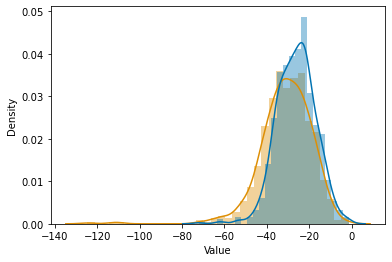

In [52]:
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Free'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[1])
sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'], color=sns.color_palette('colorblind')[0])
# sns.plot.show()

/home/kmeador14/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/kmeador14/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


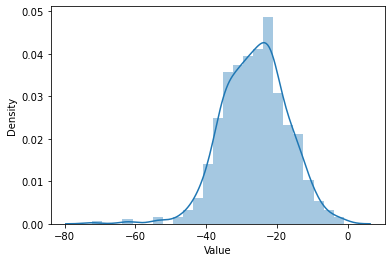

In [53]:
ax = sns.distplot(final_bar_df[final_bar_df['Protocol'] == 'Constraint'][final_bar_df['Metric'] == 'Predicted Binding Energy']['Value'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


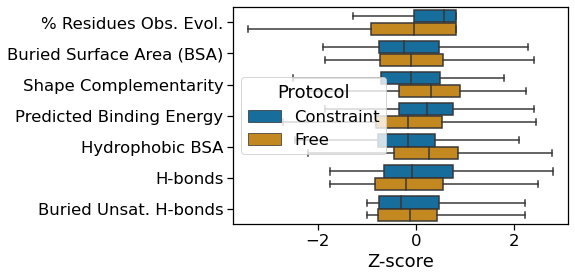

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


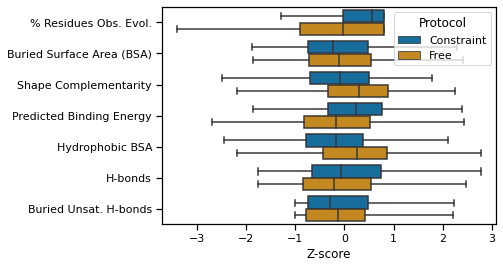

In [54]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

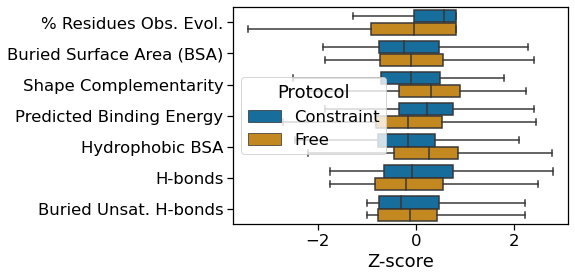

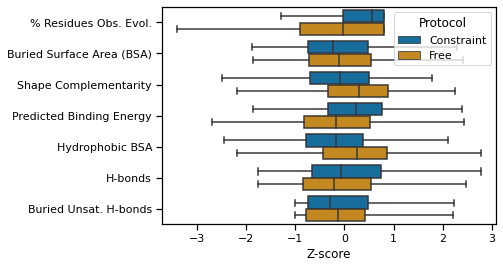

In [55]:
# plt.figure(figsize=(6, 4))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ['Times New Roman']

with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()
with sns.plotting_context("notebook", font_scale=1):
    fig, ax = plt.subplots()

    sns.boxplot(y='Metric', hue='Protocol', x='Z-score', data=final_bar_df, 
                showfliers = False, palette=sns.color_palette('colorblind'),
                order=metrics_of_interest.values())
    ax.set_ylabel('')    
#     ax.set_xlabel('')
    plt.show()

In [ ]:
protocol_specific_columns = ['int_energy_res_summary_delta', 'shape_complementarity',
                             'buns_total', 'contact_count', 'number_hbonds']
for metric in protocol_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['Metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="Protocol", y='Value', kind='box', data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

In [ ]:
bsa_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'int_area_hydrophobic'], bar_df[bar_df['Metric'] == 'int_area_polar'], bar_df[bar_df['Metric'] == 'int_area_total']])
# bar_df[bar_df['metric'] == 'int_area_hydrophobic']
# bar_df[bar_df['metric'] == 'int_area_polar']
# bar_df[bar_df['metric'] == 'int_area_total']
# display(bsa_bar_df)

In [ ]:
# with SD
# plt.figure(figsize=(100, 6))
# sns.barplot(x="metric", hue="protocol", y='Value', ci='sd', data=bsa_bar_df)
sns.catplot(x='Metric', y='Value', hue='Protocol', kind='violin', aspect=2, data=bsa_bar_df)  # hue="protocol", ci='sd'
plt.show()

# with 95% confidence interval
plt.figure(figsize=(20, 6))
sns.barplot(x='Metric', hue='Protocol', y='Value', data=bsa_bar_df)
plt.show()

In [ ]:
# .stack() takes a multiindex column header and re-orients (almost transposes) the data onto the index
bar_df = pd.DataFrame(seq_stats_protocol_df.stack().stack())
bar_df['Metric'] = bar_df.index.get_level_values(1)
bar_df['Protocol'] = bar_df.index.get_level_values(2)
bar_df = bar_df.rename({0: 'Value'}, axis=1)
display(bar_df)

In [ ]:
divergence_bar_df = pd.concat([bar_df[bar_df['Metric'] == 'divergence_interface_per_res'], bar_df[bar_df['Metric'] == 'divergence_evolution_per_res']])
box = sns.catplot(x="Metric", y='Value', hue="Protocol", kind='box', aspect=2, data=divergence_bar_df)  #  ci='sd'
# ax = sns.boxplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'
# ax = sns.swarmplot(x="metric", y='Value', hue="protocol", data=divergence_bar_df)  #, ax=box.ax)  #  ci='sd'

In [ ]:
seq_specific_columns = ['divergence_interface_per_res', 'divergence_evolution_per_res']
# display(bar_df)
combo_favor_combined_df = pd.concat([bar_df[bar_df['protocol'] == 'combo_profile'], bar_df[bar_df['protocol'] == 'favor_profile']])
combo_favor_combined_df['protocol'] = 'combination'
bar_df = pd.concat([bar_df, combo_favor_combined_df])
for metric in seq_specific_columns:
# for protocol in unique_protocols:
    protocol_bar_df = bar_df[bar_df['metric'] == metric]
#     plt.figure(figsize=(5, 5))
#     sns.barplot(x="metric", hue="protocol", y='Value', data=protocol_bar_df)
    sns.catplot(x="protocol", y='Value', kind='box', aspect=2, data=protocol_bar_df)  # hue="protocol", ci='sd'
    print(metric)
    plt.show()

## Need to add a couple of metrics to the Dataframe. All subsets are missing these...

In [ ]:
only_metrics_protocol_df = xtal_pose_df.droplevel(0, axis=1)
# only_metrics_protocol_df = columns_to_new_column(only_metrics_protocol_df, division_pairs, mode='truediv')
# display(only_metrics_protocol_df)
# only_metrics_protocol_df['percent_int_area_polar']

## Filtering by additional design filters which lead to good poses

I am going to remove designs not satisfying a couple of criteria that have been useful in past design work. This includes:

buried unsatisfied hydrogen bonds (Stranges and Khulman 2013): 2/1000A

percent polar interface area (): >30%

NOT YET number of h bonds: <10 <8?

In [ ]:
design_requirements = {'percent_int_area_polar': 0.4, 'buns_per_ang': 0.002}  #, 'number_hbonds': 10}
design_requirements.update(crystal_means)

In [8]:
filter_key_df = pd.DataFrame(master_metrics, index_col=0)
display(filter_key_df)

In [ ]:
crystal_filters = {column: {'direction': filter_key_df.loc['direction', column], 'value': design_requirements[column]} 
                   for column in design_requirements}

print('Starting designs = %d' % len(only_metrics_protocol_df))
print('Using filter parameters: %s' % str(crystal_filters))
crystal_filters_with_idx = df_filter_index_by_value(only_metrics_protocol_df, **crystal_filters)
# Take a df and retrieve the indices which have column values greater_equal/less_equal to a value depending
# on whether the column should be sorted max/min
# Args:
#     df (pandas.DataFrame): DataFrame to filter indices on
# Keyword Args:
#     kwargs (dict): {column: {'direction': 'min', 'value': 0.3, 'idx': ['0001', '0002', ...]}, ...}
for _filter in crystal_filters_with_idx:
    print('%s designs = %d' % (_filter, len(crystal_filters_with_idx[_filter]['idx'])))

In [ ]:
# print(crystal_filters_with_idx)
design_indices = {_filter: crystal_filters_with_idx[_filter]['idx'] for _filter in crystal_filters_with_idx}
# display(design_indices[0])
symmetry_and_design_filtered_idx = index_intersection(design_indices)
print('Final number of designs passing all metrics is %d' % len(symmetry_and_design_filtered_idx))
symmetry_and_design_filtered_df = only_metrics_protocol_df.loc[symmetry_and_design_filtered_idx, :]